# Acelen S10 - Time Series Project - Final Version

### `1- Importing Libraries`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pmdarima lime --no-warn-script-location -U -q >nul 2>&1

In [ ]:
# Importing the libraries
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from IPython.core.display import display, HTML
import warnings

import lime
import lime.lime_tabular
from itertools import combinations
from prophet import Prophet
import pmdarima as pm

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import acf, ccf, adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR, SimpleExpSmoothing, Holt, ExponentialSmoothing

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

os.chdir('.')
sns.set_palette("deep")
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

display(HTML("<style>.container { width:100% !important; }</style>"))

### `2- Recovering Data`

In [ ]:
file_path = '/content/Comparativo_Acelen_20240708.csv'
data = pd.read_csv(file_path,sep=';')
# Converter a coluna 'Date' para datetime
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data[data['Date'].dt.year == 2024]
data = data[['Date','Acelen_S10','cambio','Europa', 'Golfo', 'PPI']].dropna().copy(deep='True')
data['cambio'] = data['cambio']*1000

In [ ]:
# Função para limpar e converter dados numéricos
def clean_numeric_data(value):
    if isinstance(value, str):
        return float(value.replace(' ', '').replace('.', '').replace(',', '.'))
    return value

# Aplicar a função de limpeza
for column in data.columns[1:]:
    data[column] = data[column].apply(clean_numeric_data)

# Configurar a data como coluna e reindexar para completar as datas faltantes
data.set_index('Date', inplace=True)
idx = pd.date_range(data.index.min(), data.index.max())
data = data.reindex(idx).rename_axis('Date').reset_index()

# Substituir zeros usando ffill para garantir que todos os valores sejam preenchidos
for column in data.columns[1:]:  # Ignorar a coluna 'Date'
    # Primeiro, substituir zeros com NaN para permitir o uso de ffill
    data[column].replace(0, np.nan, inplace=True)
    # Aplicar ffill
    data[column].ffill(inplace=True)
    # Se ainda houver NaNs (caso a série começasse com zero), aplicar bfill
    data[column].bfill(inplace=True)

# Checar se há algum NaN ou zero restante
assert (data.set_index('Date') == 0).any().any() == False, "Ainda há zeros no DataFrame."
assert data.set_index('Date').isnull().any().any() == False, "Ainda há NaNs no DataFrame."

# Mostrar os dados preparados
print(data.tail(10))

          Date  Acelen_S10  cambio   Europa    Golfo      PPI
180 2024-06-30      3789.8  5558.9  4322.88  4377.63  4084.03
181 2024-07-01      3789.8  5589.3  4490.63  4463.06  4132.14
182 2024-07-02      3789.8  5667.7  4581.99  4606.42  4181.63
183 2024-07-03      3789.8  5586.3  4525.10  4457.87  4112.91
184 2024-07-04      3856.7  5483.9  4525.10  4413.17  4112.91
185 2024-07-05      3856.7  5497.0  4525.10  4447.07  4112.91
186 2024-07-06      3856.7  5497.0  4525.10  4447.07  4112.91
187 2024-07-07      3856.7  5497.0  4525.10  4447.07  4112.91
188 2024-07-08      3856.7  5472.0  4344.85  4325.62  3972.80
189 2024-07-09      3856.7  5438.7  4213.75  4223.15  3874.47


- Importamos as Bibliotecas: Usamos algumas ferramentas de computação, como pandas, numpy, matplotlib e seaborn, que nos ajudam a lidar com os dados e criar gráficos.
- Definimos a Pasta de Trabalho: Indicamos onde estão os nossos arquivos para que o programa saiba onde buscar.
- Escolhemos as Cores dos Gráficos: Decidimos como queremos que nossos gráficos fiquem coloridos.
- Ignoramos Mensagens que Não Importam: Configuramos o programa para não nos mostrar mensagens chatas que não são importantes.
- Estilo dos Gráficos: Escolhemos um estilo específico para nossos gráficos, para que eles tenham uma aparência bonita.
- Carregamos os Dados: Pegamos os números de vendas de diesel de um arquivo.
- Filtramos os Dados: Escolhemos apenas as partes dos números que são importantes para nós

Agora, com os dados em mãos, podemos continuar olhando para eles, fazendo gráficos para ver como estão se comportando e talvez fazendo alguns cálculos para entender melhor o que está acontecendo.

### `3 - Time series visualization`

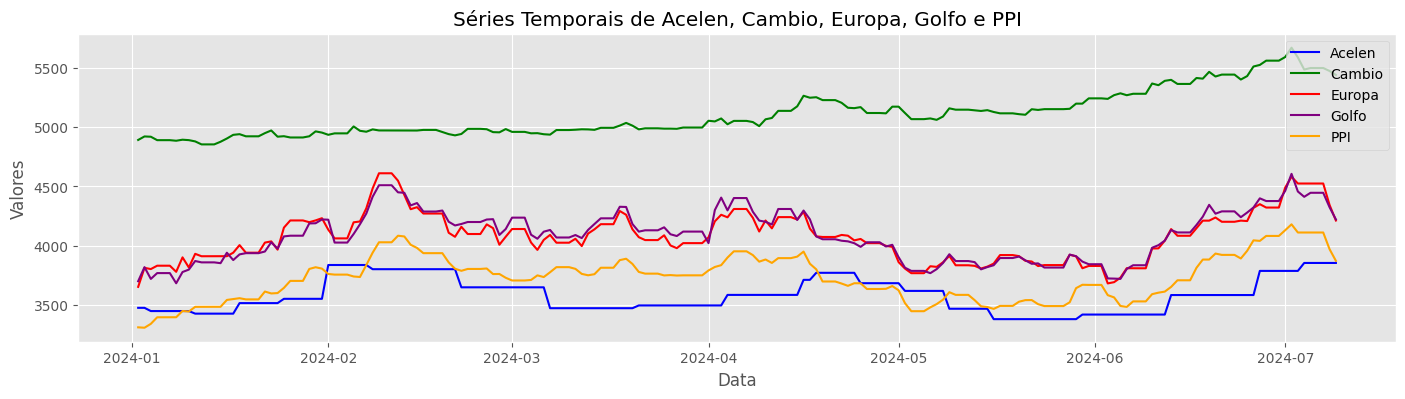

In [ ]:
plt.figure(figsize=(17, 4))

# Plotar cada série com uma cor específica
plt.plot(data['Date'], data['Acelen_S10'], label='Acelen', color='blue')
plt.plot(data['Date'], data['cambio'], label='Cambio', color='green')
plt.plot(data['Date'], data['Europa'], label='Europa', color='red')
plt.plot(data['Date'], data['Golfo'], label='Golfo', color='purple')
plt.plot(data['Date'], data['PPI'], label='PPI', color='orange')

# Adicionar títulos e rótulos
plt.title('Séries Temporais de Acelen, Cambio, Europa, Golfo e PPI')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()

plt.grid(True)

### `3.1 - Smoothing Time Series`

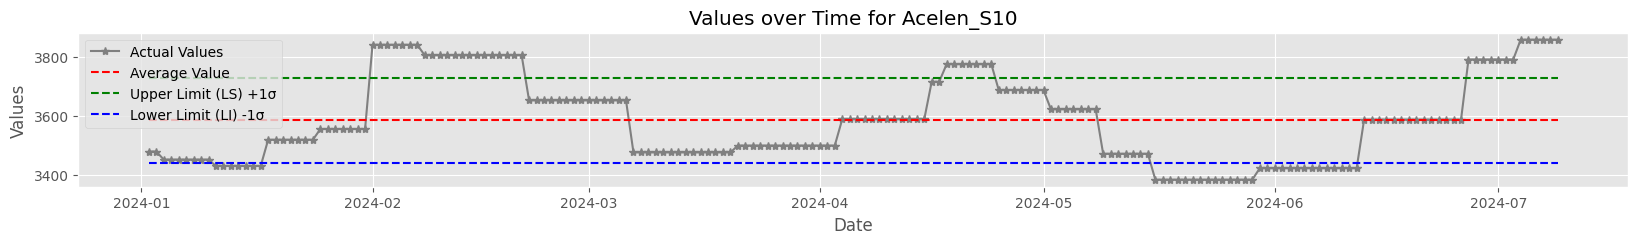

Mean Square Error for Acelen_S10: 20716.6246770083



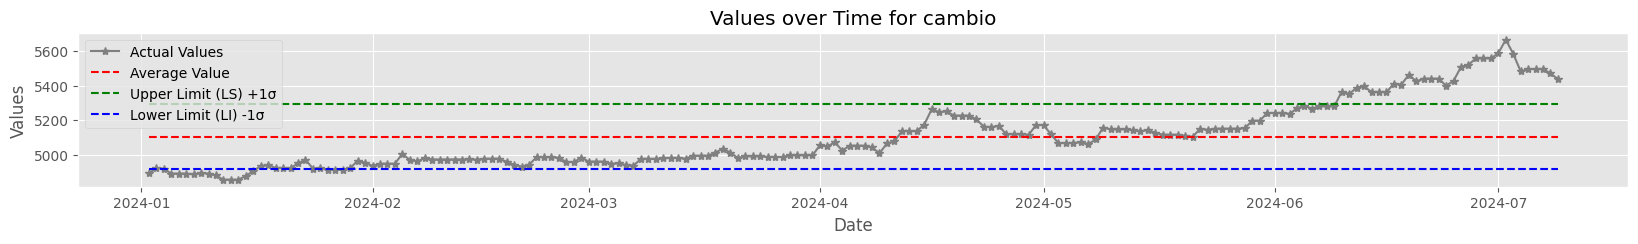

Mean Square Error for cambio: 35549.208199723



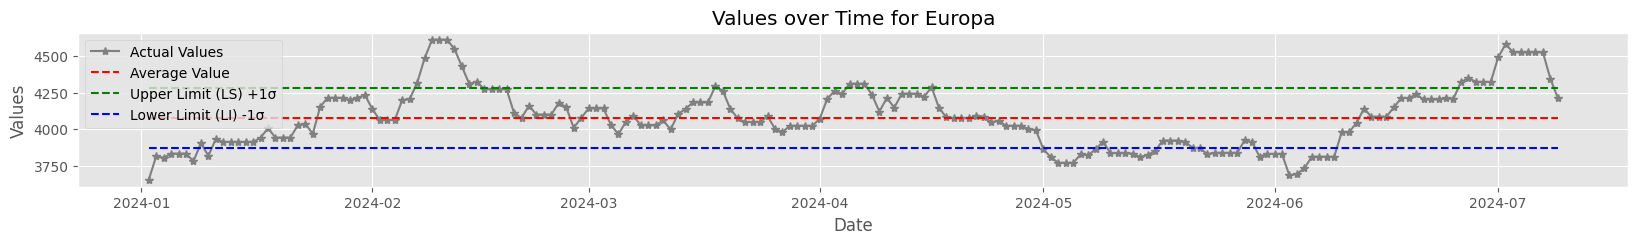

Mean Square Error for Europa: 41941.61643169254



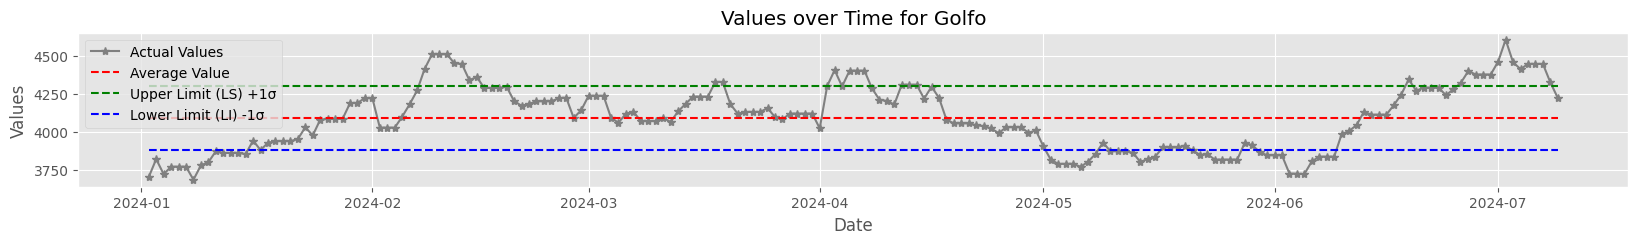

Mean Square Error for Golfo: 44311.13128035731



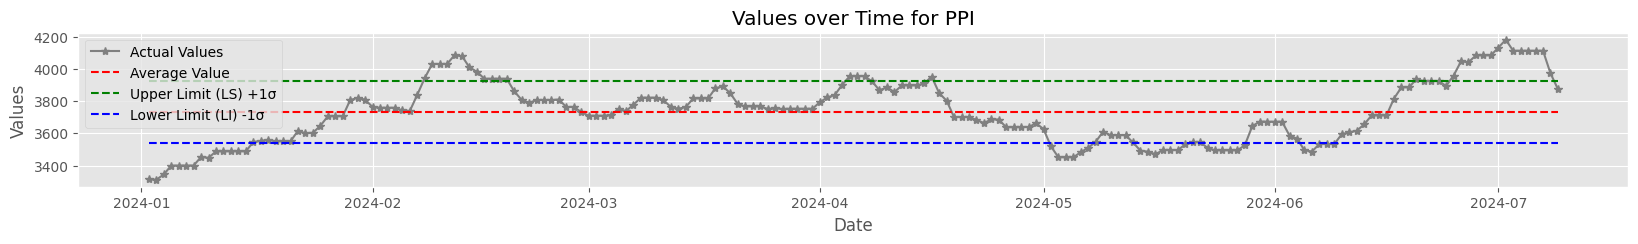

Mean Square Error for PPI: 36734.963647268705



In [ ]:
# Função de plotagem com linhas de limite baseadas em desvio padrão
def run_sequence_plot(x, y, y_avg, std_dev, title, num_std=1):
    plt.figure(figsize=(20,2))
    plt.plot(x, y, marker='*', color='gray', label='Actual Values')
    plt.plot(x, y_avg, 'r--', label='Average Value')

    # Calcular e plotar linhas de limite superior e inferior usando desvio padrão
    upper_limit = y_avg + (num_std * std_dev)
    lower_limit = y_avg - (num_std * std_dev)
    plt.plot(x, upper_limit, 'g--', label=f'Upper Limit (LS) +{num_std}σ')
    plt.plot(x, lower_limit, 'b--', label=f'Lower Limit (LI) -{num_std}σ')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

def mse(observations, estimates):
    observations = np.array(observations)
    estimates = np.array(estimates)
    assert len(observations) == len(estimates), "Arrays must be of equal length"

    difference = observations - estimates
    sq_diff = difference ** 2
    mse = np.mean(sq_diff)

    return mse

# Preparação dos dados
columns_of_interest = ['Acelen_S10', 'cambio', 'Europa', 'Golfo', 'PPI']
data['Date'] = pd.to_datetime(data['Date'])  # Assegurar que a coluna Date é tratada como datetime

# Loop para processar cada coluna de interesse
for col in columns_of_interest:
    time_series_avg = np.mean(data[col])
    std_dev = np.std(data[col])  # Calcular o desvio padrão
    data[col + '_avg'] = np.full(shape=len(data), fill_value=time_series_avg, dtype='float')

    # Chamar a função run_sequence_plot com os limites definidos pelo desvio padrão
    run_sequence_plot(data['Date'], data[col], data[col + '_avg'], std_dev, title=f"Values over Time for {col}", num_std=1)

    mse_value = mse(data[col].values, data[col + '_avg'])
    print(f"Mean Square Error for {col}: {mse_value}\n")

    data.drop([col + '_avg'], axis=1, inplace=True)

### `3.2 - Gráfico de matriz de correlação parcial, Pearson, Kendal e Spearman`

statistic       p_value Normality (alpha=0.05)
Acelen_S10   0.919201  1.008560e-08             Not Normal
cambio       0.890560  1.424222e-10             Not Normal
Europa       0.970292  4.592534e-04             Not Normal
Golfo        0.973532  1.146432e-03             Not Normal
PPI          0.982677  1.891887e-02             Not Normal

Matriz de correlação parcial:


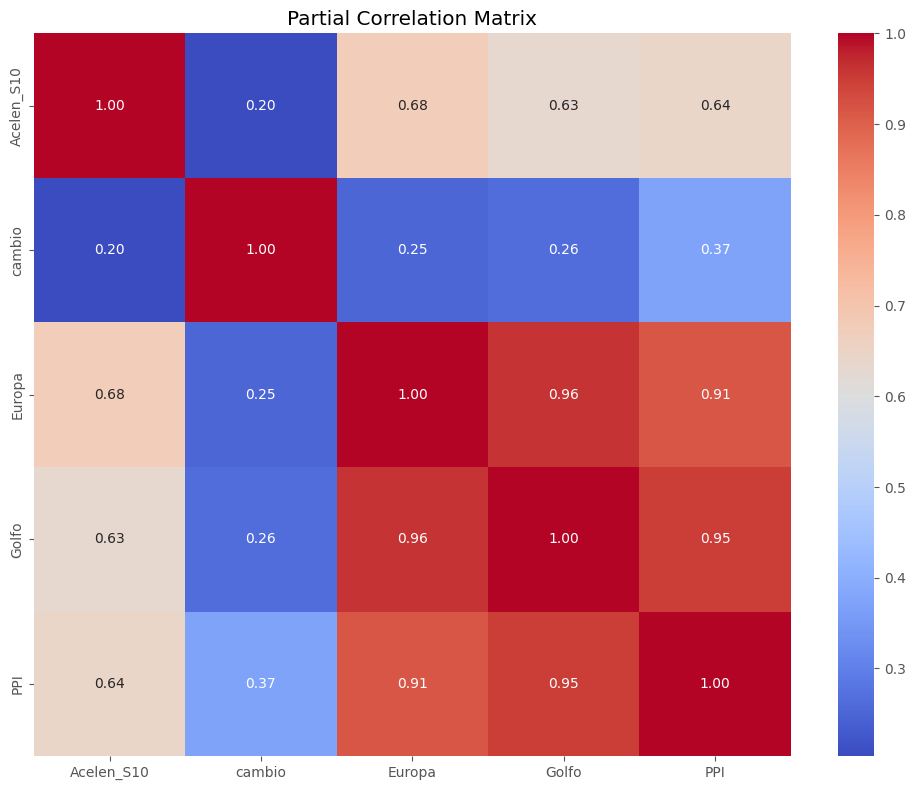

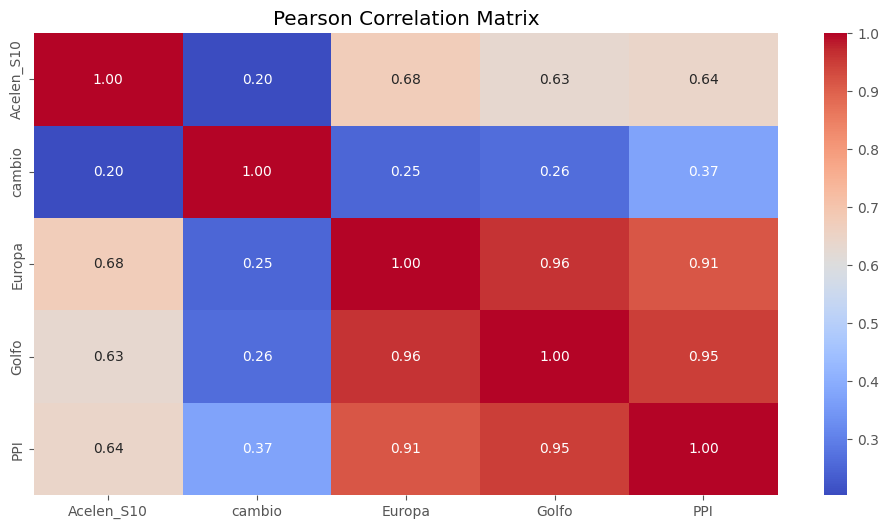

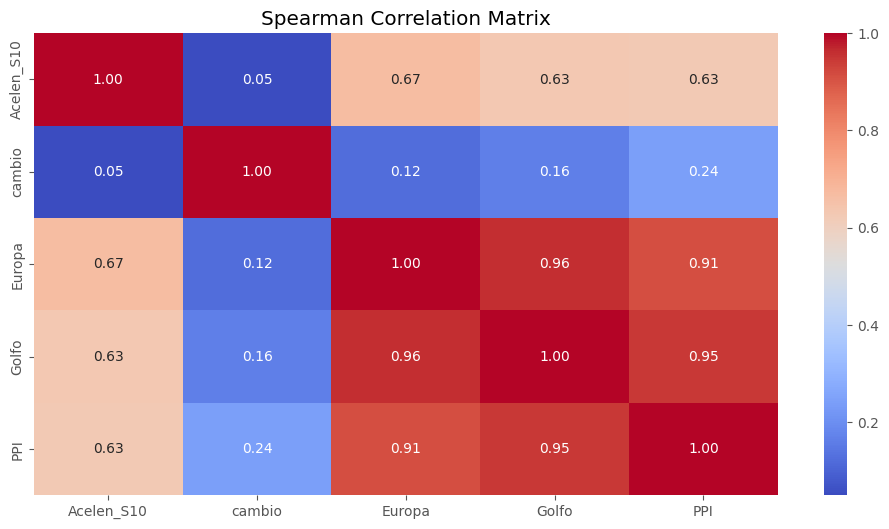

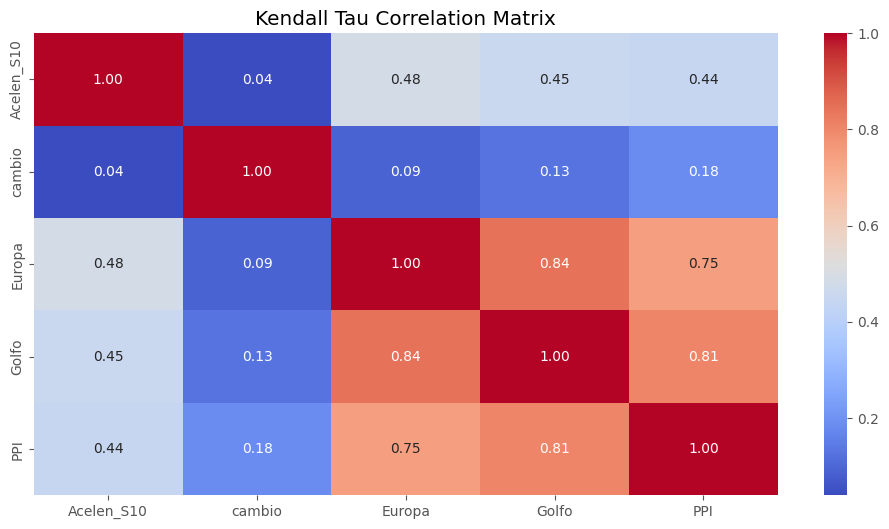

In [ ]:
columns_of_interest = ['Acelen_S10','cambio','Europa', 'Golfo', 'PPI']
interference_col = ['Europa', 'Golfo', 'PPI', 'cambio']
correlation_matrix = data[columns_of_interest].corr()

def normality_test(df, colunas):
    results= {}
    for col in colunas:
        stat, p_value = stats.shapiro(data[col].dropna())
        results[col] = {"statistic":stat, 'p_value':p_value}
    return results
normality_result = normality_test(data,columns_of_interest)
normality_df = pd.DataFrame(normality_result).T
normality_df['Normality (alpha=0.05)'] = normality_df['p_value'].apply(lambda x: 'Normal' if x > 0.05 else 'Not Normal')
display(normality_df)



# Gráfico de matriz de correlação parcial
data_with_const = sm.add_constant(data[columns_of_interest])

# Calcular o VIF para verificar a multicolinearidade
vif_data = pd.DataFrame()
vif_data["variable"] = data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])]

# Calculando a correlação parcial
partial_corr_matrix = data[columns_of_interest].corr()

# Visualizar a matriz de correlação parcial
print("Matriz de correlação parcial:")
plt.figure(figsize=(10, 8))
sns.heatmap(partial_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Partial Correlation Matrix')
plt.tight_layout()
plt.show()

# Correlação de Pearson
pearson_corr = data[columns_of_interest].corr(method='pearson')
# Correlação de Spearman
spearman_corr = data[columns_of_interest].corr(method='spearman')
# Correlação de Kendall
kendall_corr = data[columns_of_interest].corr(method='kendall')

def plot_heatmap(corr, title):
    plt.figure(figsize=(12, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

plot_heatmap(pearson_corr, 'Pearson Correlation Matrix')
plot_heatmap(spearman_corr, 'Spearman Correlation Matrix')
plot_heatmap(kendall_corr, 'Kendall Tau Correlation Matrix')

* Com base nos resultados dos testes de normalidade, podemos observar que nenhuma das variáveis segue uma distribuição normal, pois todas têm valores de p significativamente menores que 0.05. Isso sugere que as variáveis podem precisar de transformações para melhorar a modelagem e análise subsequente.


### `4-Extracting Time Series Components and Visualizing Time Series Components`

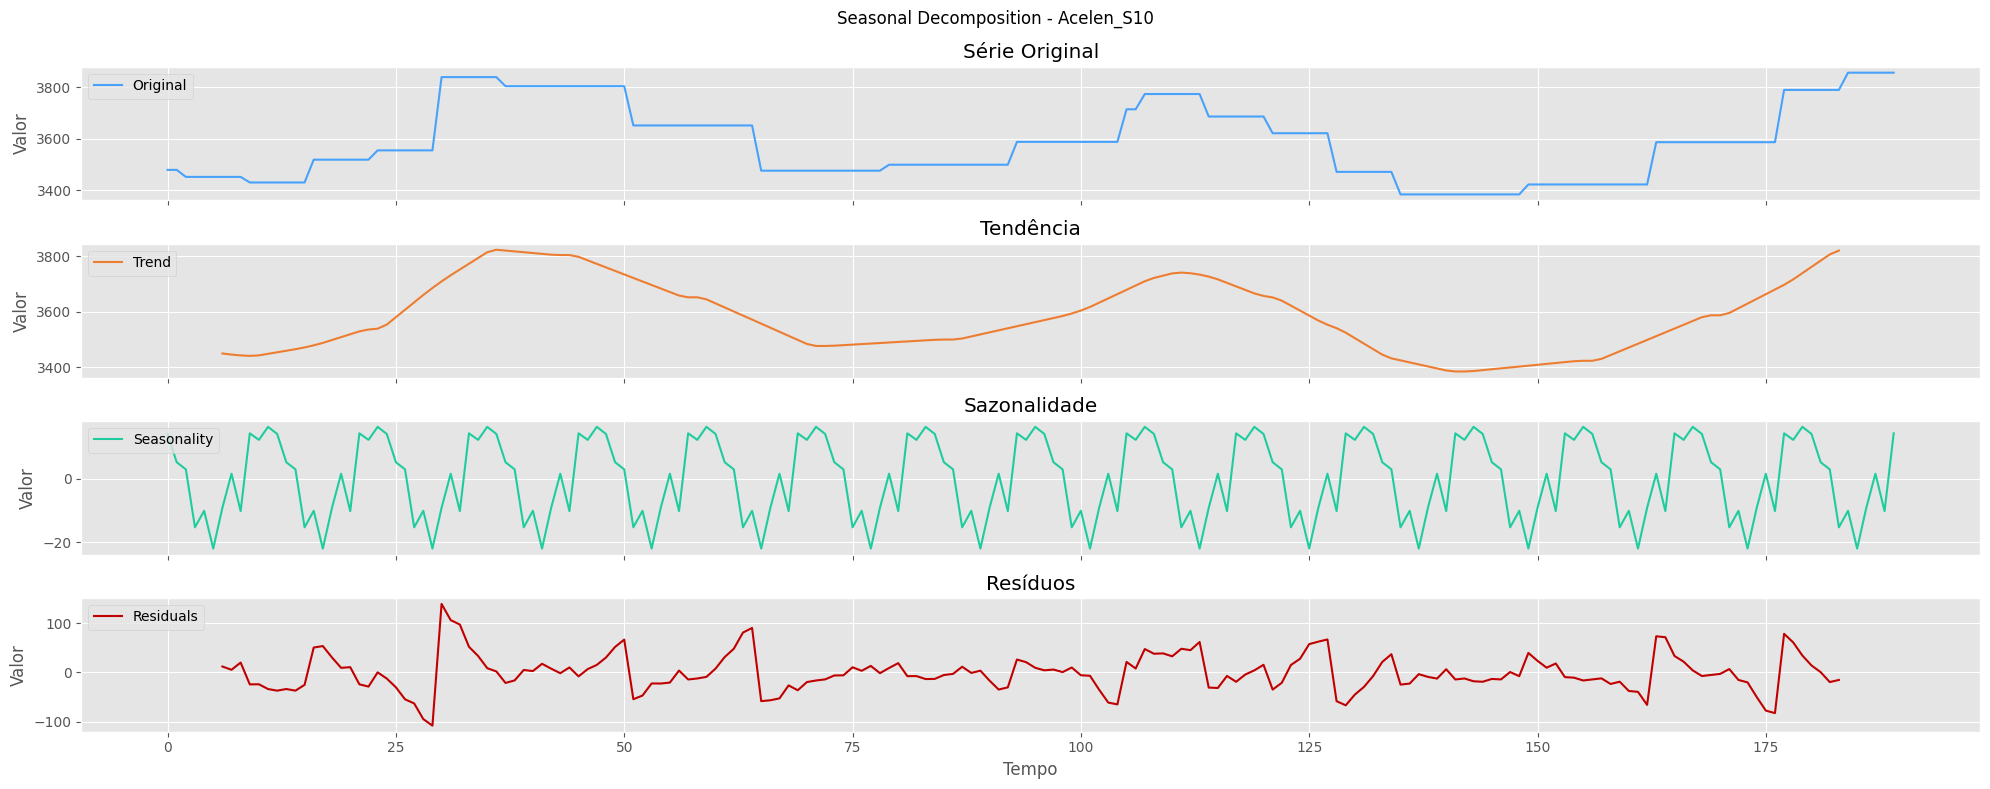

In [ ]:
# Decomposição da série temporal
decomposition = sm.tsa.seasonal_decompose(data['Acelen_S10'], model='additive', period=12)

# Obter os componentes da decomposição
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Configuração do plot
fig, axes = plt.subplots(4, 1, figsize=(20, 8), sharex=True)
fig.suptitle(f'Seasonal Decomposition - Acelen_S10', fontsize=12)

# Plotar a série original
axes[0].plot(data['Acelen_S10'], label='Original', c="#48A1FA")
axes[0].legend(loc='upper left')
axes[0].set_title('Série Original')
axes[0].set_ylabel('Valor')

# Plotar a tendência
axes[1].plot(trend, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left')
axes[1].set_title('Tendência')
axes[1].set_ylabel('Valor')

# Plotar a sazonalidade
axes[2].plot(seasonal, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left')
axes[2].set_title('Sazonalidade')
axes[2].set_ylabel('Valor')

# Plotar os resíduos
axes[3].plot(residual, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left')
axes[3].set_title('Resíduos')
axes[3].set_ylabel('Valor')
axes[3].set_xlabel('Tempo')

plt.tight_layout()
plt.show()

Nós estamos observando aqui um gráfico de decomposição sazonal de uma série temporal, que está dividido em quatro partes distintas:

1. No primeiro subgráfico, que se refere à **Série Original**, nós temos a representação completa dos dados ao longo do tempo. A linha azul que vocês veem ilustra os valores que foram medidos, e embora não possamos ver as datas exatas, o eixo horizontal indica o passar do tempo enquanto o eixo vertical mostra a magnitude desses valores.

2. Movendo para o segundo subgráfico, a **Tendência**, aqui nós identificamos a direção geral ou o movimento da série ao longo do tempo, excluindo as flutuações de curto prazo. Esta linha laranja suavizada é o resultado de técnicas estatísticas que nos ajudam a visualizar a tendência subjacente nos dados.

3. No terceiro subgráfico, a **Sazonalidade**, é onde nós destacamos os padrões que se repetem em intervalos regulares. A linha verde evidencia essas oscilações periódicas que podem ser causadas por uma variedade de fatores recorrentes, como comportamento do consumidor, eventos periódicos ou variações climáticas.

4. Por fim, no quarto subgráfico dos **Resíduos**, nós temos aquilo que sobra depois de considerarmos a tendência e a sazonalidade. A linha vermelha mostra as variações nos dados que ainda permanecem inexplicadas, o que pode ser descrito como o ruído aleatório ou as flutuações que não são capturadas pelos outros componentes da série.

Este processo de decomposição é extremamente valioso para nós, pois nos permite entender e modelar os diferentes componentes que influenciam uma série de dados ao longo do tempo. É uma técnica que aplicamos em diversos campos, desde a economia até a meteorologia, pois fornece insights cruciais sobre como e por que os dados podem variar em diferentes períodos.

### `5-Checking for Stationarity, White Noise, Random walk`

#### `5.1. Encontrando a média da série temporal`

##### `5.1.1. Gráficos de Autocorrelação`


ADF Statistic for Acelen_S10: -3.563405005205354
p-value for Acelen_S10: 0.006500442100041001
Critical Values:
	1%: -3.4682803641749267
	5%: -2.8782017240816327
	10%: -2.5756525795918366
Os dados para Acelen_S10 são estacionários com um nível de significância de 5%.


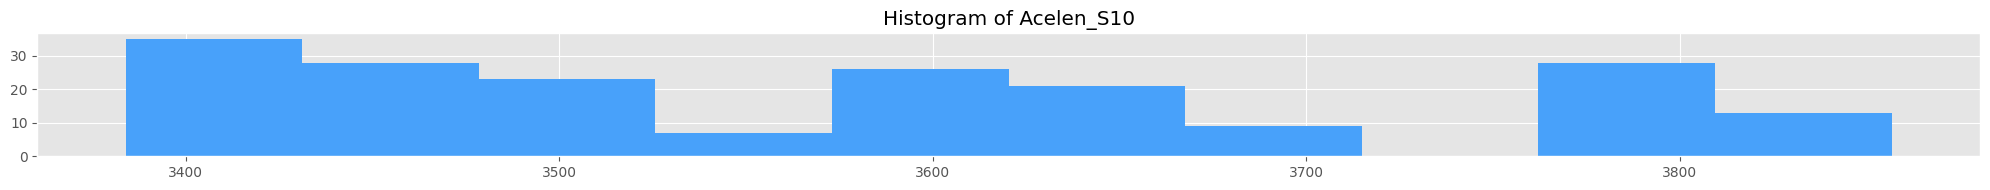

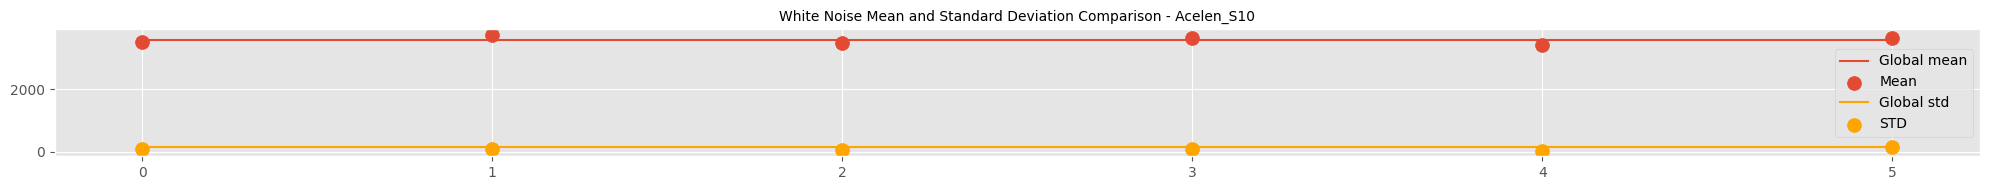

ADF Statistic for cambio: -0.0713854875554437
p-value for cambio: 0.9522151119462963
Critical Values:
	1%: -3.4682803641749267
	5%: -2.8782017240816327
	10%: -2.5756525795918366
Os dados para cambio não são estacionários, indicando a presença de uma raiz unitária.


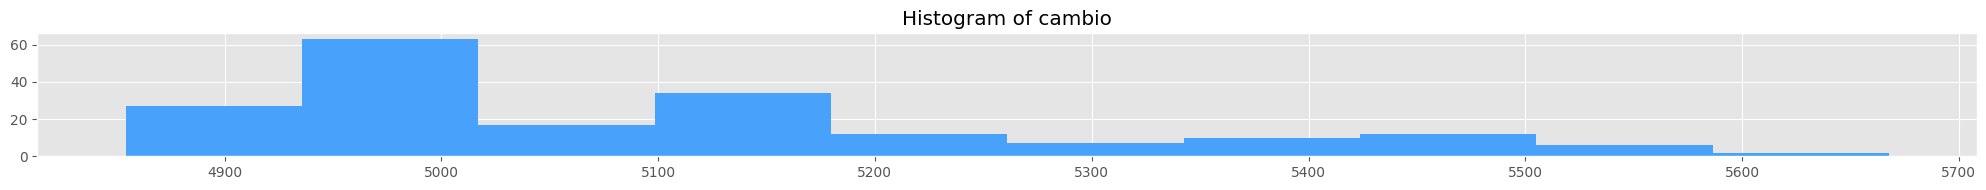

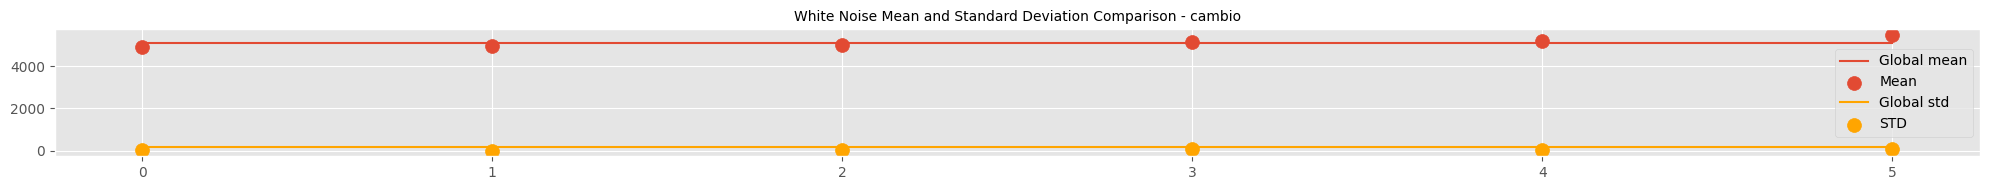

ADF Statistic for Europa: -2.5156510019857428
p-value for Europa: 0.11171255865730362
Critical Values:
	1%: -3.465620397124192
	5%: -2.8770397560752436
	10%: -2.5750324547306476
Os dados para Europa não são estacionários, indicando a presença de uma raiz unitária.


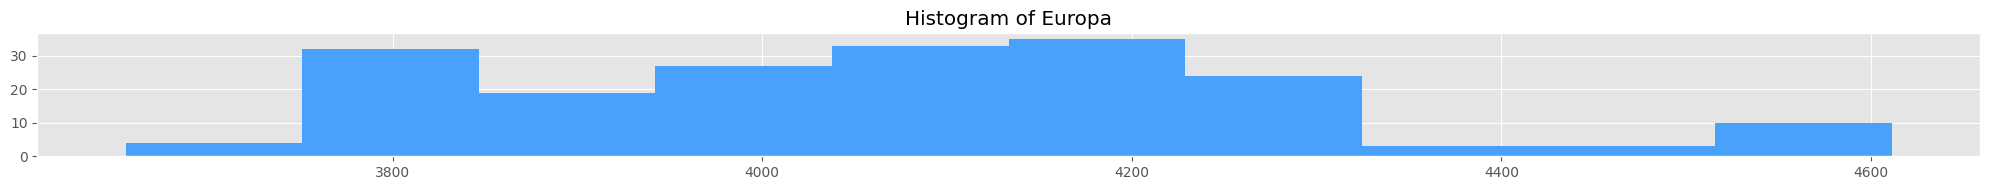

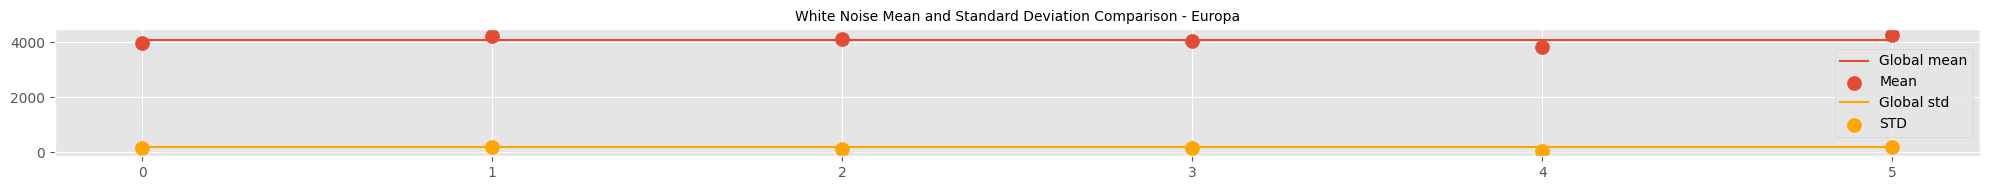

ADF Statistic for Golfo: -2.312229318376652
p-value for Golfo: 0.16805410335109305
Critical Values:
	1%: -3.465620397124192
	5%: -2.8770397560752436
	10%: -2.5750324547306476
Os dados para Golfo não são estacionários, indicando a presença de uma raiz unitária.


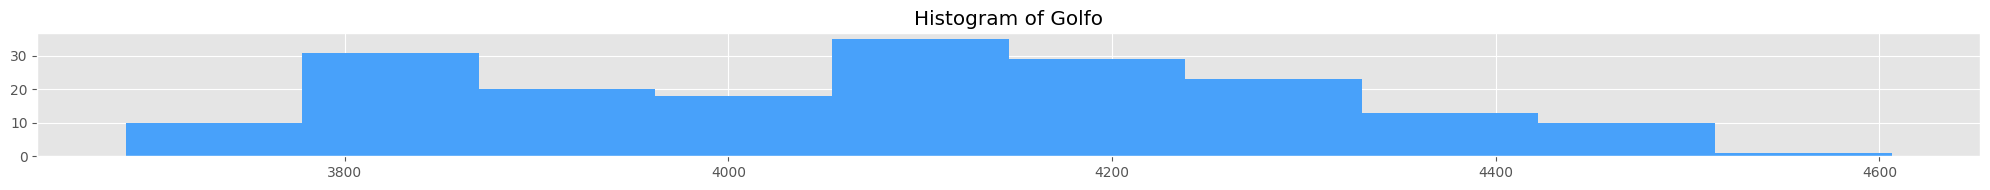

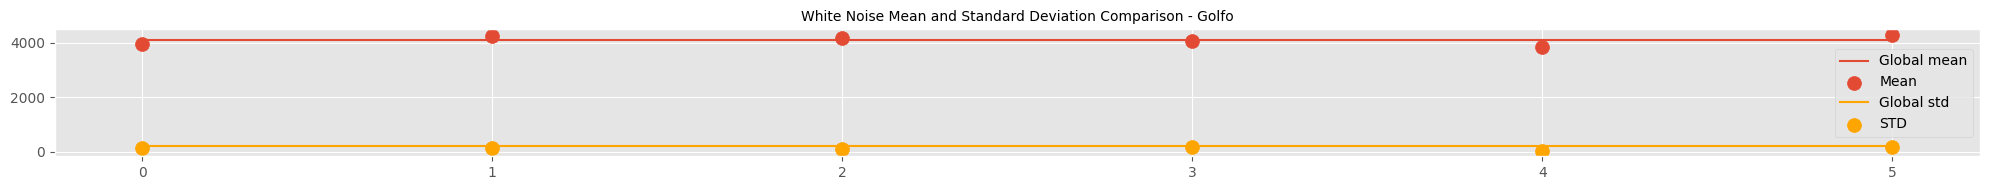

ADF Statistic for PPI: -2.4526516053097907
p-value for PPI: 0.12742367955587824
Critical Values:
	1%: -3.4672111510631
	5%: -2.877734766803841
	10%: -2.575403364197531
Os dados para PPI não são estacionários, indicando a presença de uma raiz unitária.


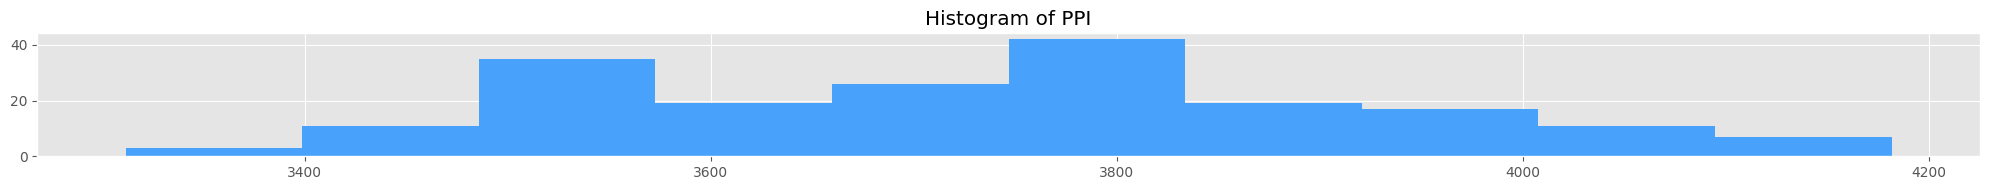

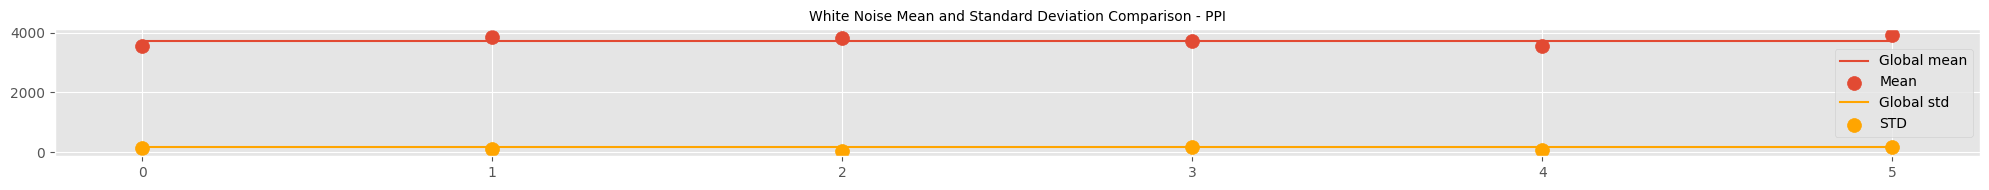

In [ ]:
num_days = data.shape[0]
days_per_segment = 30
num_segments = max(1, num_days // days_per_segment)

# Função para o teste ADF
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Statistic for {title}: {result[0]}")
    print(f"p-value for {title}: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    if result[1] < 0.05:
        print(f"Os dados para {title} são estacionários com um nível de significância de 5%.")
    else:
        print(f"Os dados para {title} não são estacionários, indicando a presença de uma raiz unitária.")

for col in columns_of_interest:
    # Teste ADF
    adf_test(data[col], title=col)
    # Histograma
    data[col].hist(color='#48A1FA', figsize=(20, 2))
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()

    ts_chunks = np.array_split(data[col], num_segments)
    means = [np.round(chunk.mean(), 2) for chunk in ts_chunks]
    stds = [np.round(chunk.std(), 2) for chunk in ts_chunks]
    mean_time_axis = np.arange(len(means))
    std_time_axis = np.arange(len(stds))

    plt.figure(figsize=(20, 2))
    plt.title(f'White Noise Mean and Standard Deviation Comparison - {col}', size=10)
    plt.plot(mean_time_axis, [data[col].mean()] * len(means), label='Global mean', lw=1.5)
    plt.scatter(mean_time_axis, y=means, label='Mean', s=100)
    plt.plot(std_time_axis, [data[col].std()] * len(stds), label='Global std', lw=1.5, color='orange')
    plt.scatter(std_time_axis, y=stds, label='STD', color='orange', s=100)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### `5.1.2 - cross-correlation`

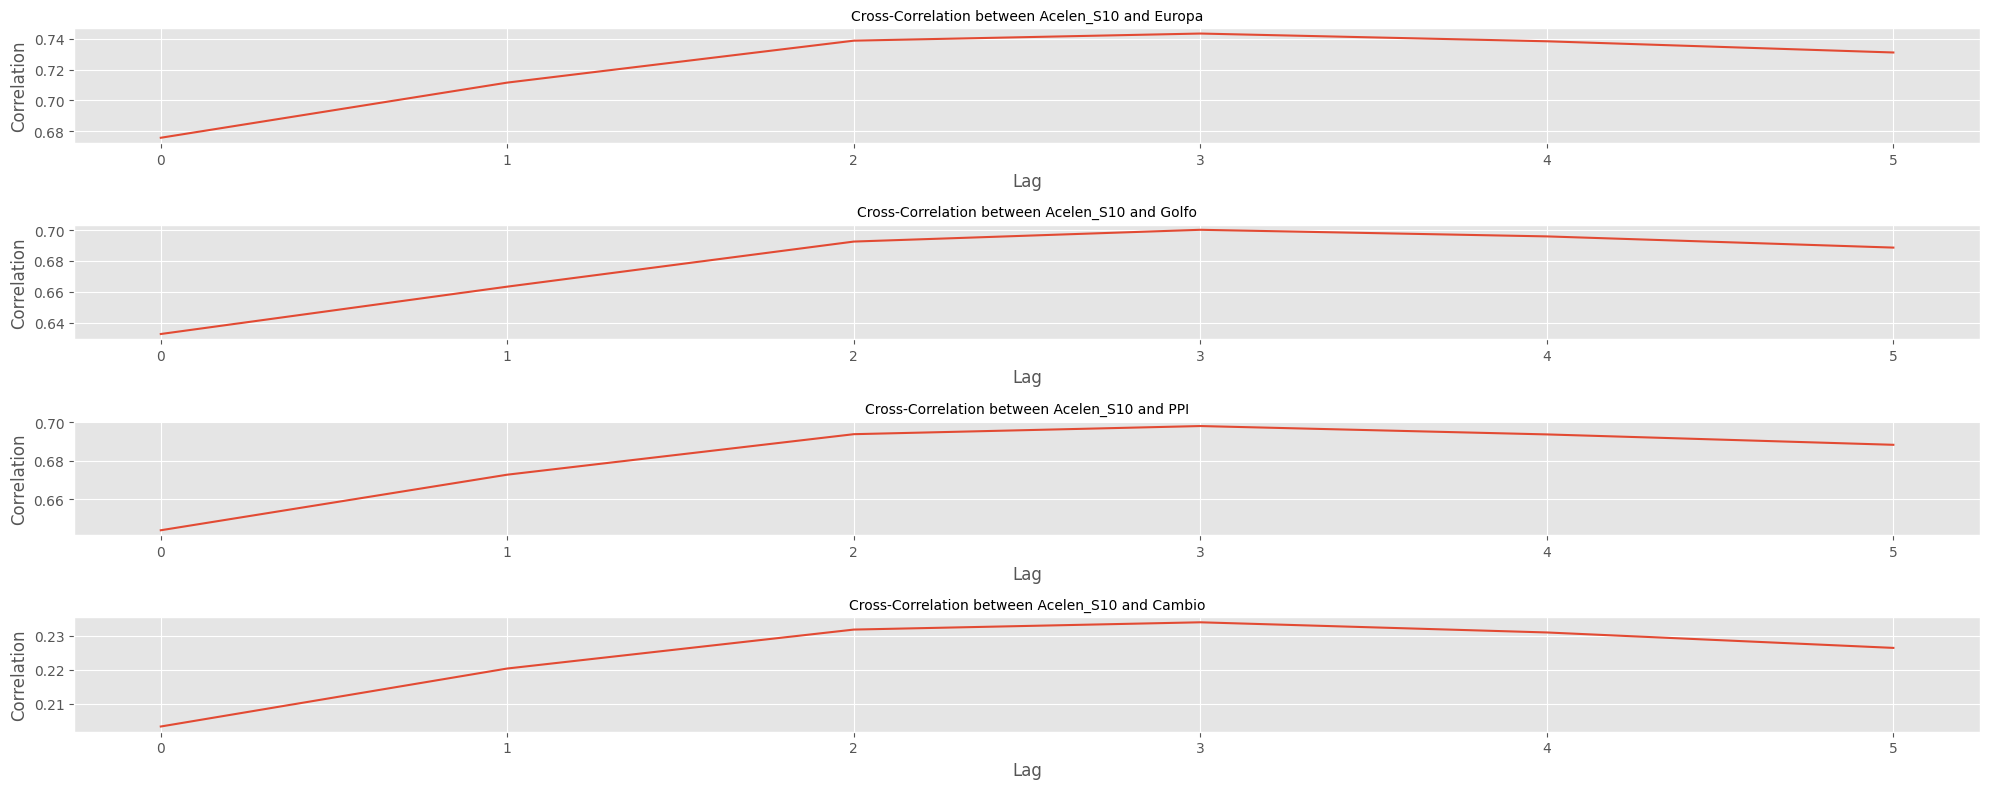

In [ ]:
# Realiza correlação cruzada para relacionamentos defasados
lags = num_segments
ccf_europa = ccf(data['Acelen_S10'], data['Europa'])[:lags]
ccf_golfo = ccf(data['Acelen_S10'], data['Golfo'])[:lags]
ccf_ppi = ccf(data['Acelen_S10'], data['PPI'])[:lags]
ccf_cambio = ccf(data['Acelen_S10'], data['cambio'])[:lags]

# Plotar cross-correlation
plt.figure(figsize=(20, 8))
plt.subplot(411)
plt.plot(np.arange(lags), ccf_europa)
plt.title('Cross-Correlation between Acelen_S10 and Europa', size=10)
plt.xlabel('Lag')
plt.ylabel('Correlation')

plt.subplot(412)
plt.plot(np.arange(lags), ccf_golfo)
plt.title('Cross-Correlation between Acelen_S10 and Golfo', size=10)
plt.xlabel('Lag')
plt.ylabel('Correlation')

plt.subplot(413)
plt.plot(np.arange(lags), ccf_ppi)
plt.title('Cross-Correlation between Acelen_S10 and PPI', size=10)
plt.xlabel('Lag')
plt.ylabel('Correlation')

plt.subplot(414)
plt.plot(np.arange(lags), ccf_cambio)
plt.title('Cross-Correlation between Acelen_S10 and Cambio', size=10)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()

#### `5.1.3 - Autocorrelation on first-order difference`

ACF values for Acelen_S10: [ 1.    0.95  0.9   0.85  0.8   0.75  0.7   0.66  0.6   0.55  0.49  0.44
  0.39  0.33  0.29  0.22  0.15  0.08  0.02 -0.05 -0.11 -0.18 -0.23]


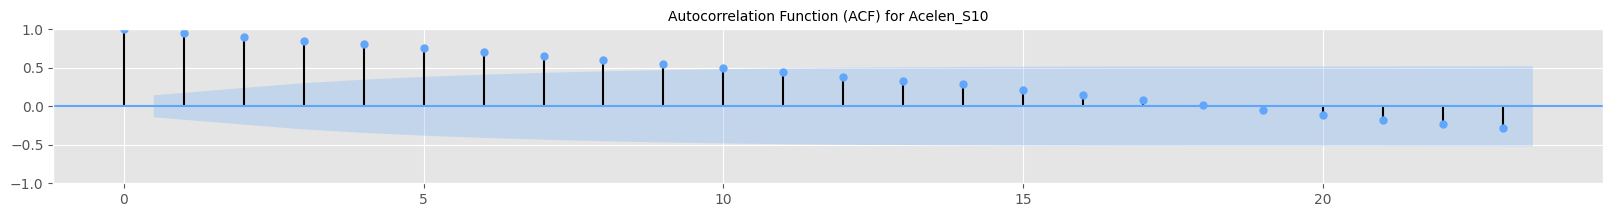

ACF values for cambio: [1.   0.98 0.96 0.93 0.91 0.89 0.86 0.83 0.8  0.78 0.75 0.72 0.69 0.67
 0.65 0.62 0.6  0.58 0.56 0.54 0.52 0.5  0.48]


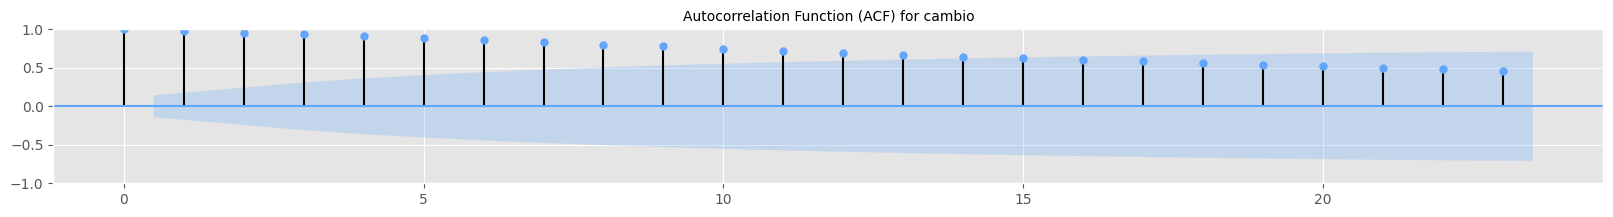

ACF values for Europa: [ 1.    0.94  0.88  0.81  0.74  0.67  0.6   0.54  0.5   0.46  0.42  0.39
  0.35  0.32  0.28  0.24  0.2   0.16  0.12  0.08  0.03 -0.01 -0.05]


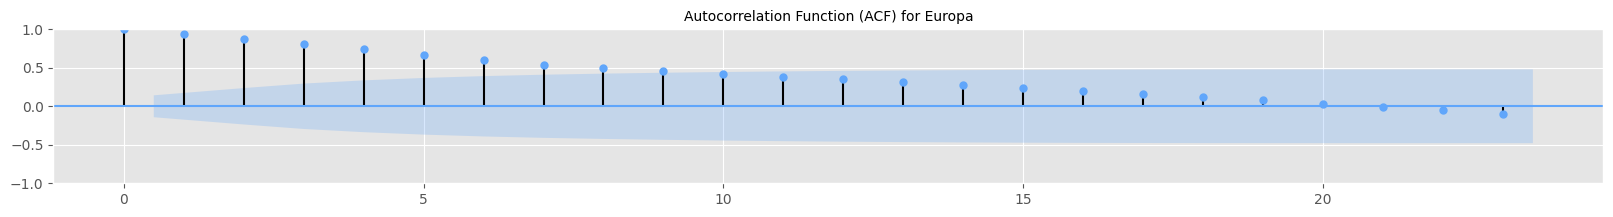

ACF values for Golfo: [ 1.    0.95  0.89  0.83  0.78  0.72  0.67  0.62  0.58  0.55  0.51  0.47
  0.43  0.38  0.34  0.3   0.25  0.22  0.18  0.13  0.09  0.04 -0.01]


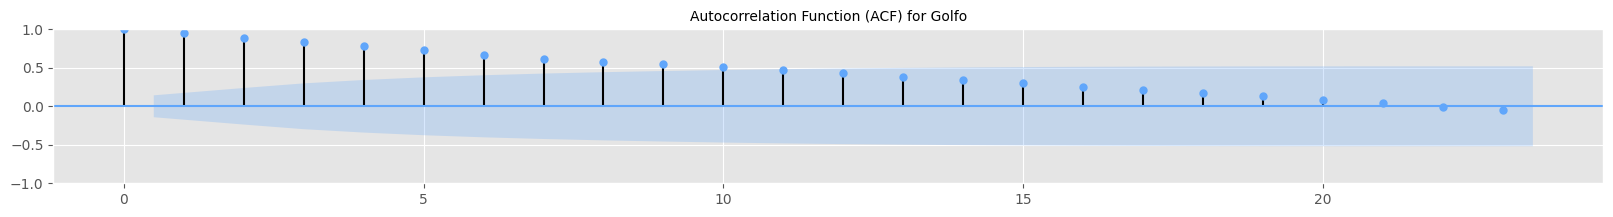

ACF values for PPI: [ 1.    0.96  0.91  0.86  0.8   0.74  0.69  0.64  0.59  0.55  0.51  0.46
  0.4   0.35  0.3   0.25  0.2   0.16  0.11  0.07  0.03 -0.01 -0.05]


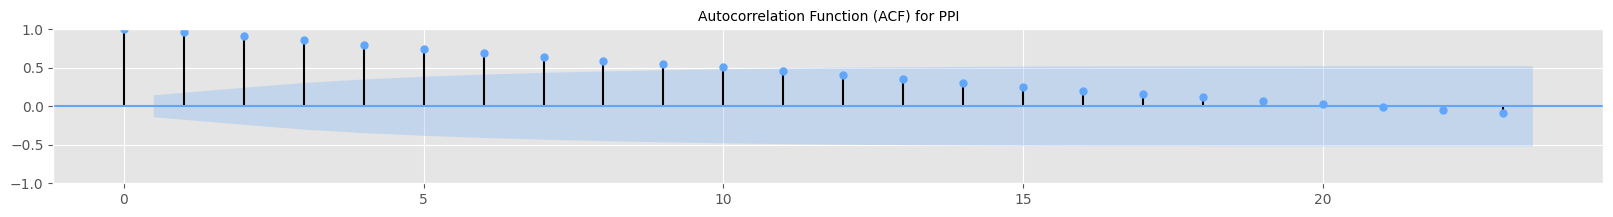

In [ ]:
for col in columns_of_interest:
    col_sales = data[col].dropna()
    # Calcula os valores de ACF
    ac_values = np.round(acf(col_sales, fft=False), 2)
    print(f'ACF values for {col}: {ac_values}')
    # Plotagem da função de autocorrelação (ACF)
    fig, ax = plt.subplots(figsize=(20, 2))

    plot_acf(col_sales, ax=ax, color='#60A6FB', vlines_kwargs={"colors": '#000000'})

    for item in ax.collections:
        if isinstance(item, PolyCollection):
            item.set_facecolor('#60A6FB')

    plt.title(f'Autocorrelation Function (ACF) for {col}', size=10)
    plt.show()


#### `5.1.4 - Differentiate series to achieve stationarity`

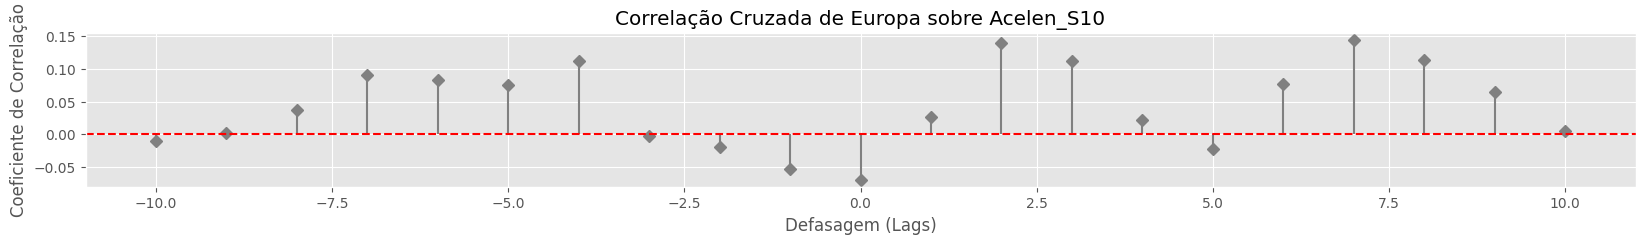

Europa influencia Acelen_S10 nos seguintes períodos: [-4, 2, 3, 7, 8]




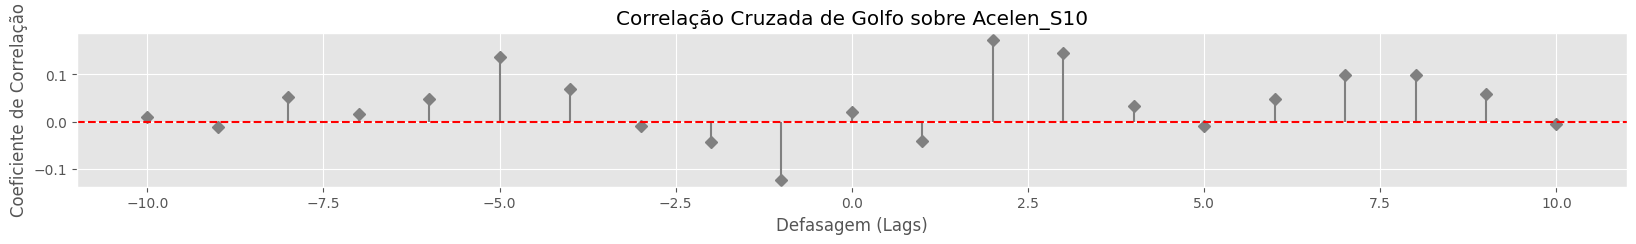

Golfo influencia Acelen_S10 nos seguintes períodos: [-5, -1, 2, 3]




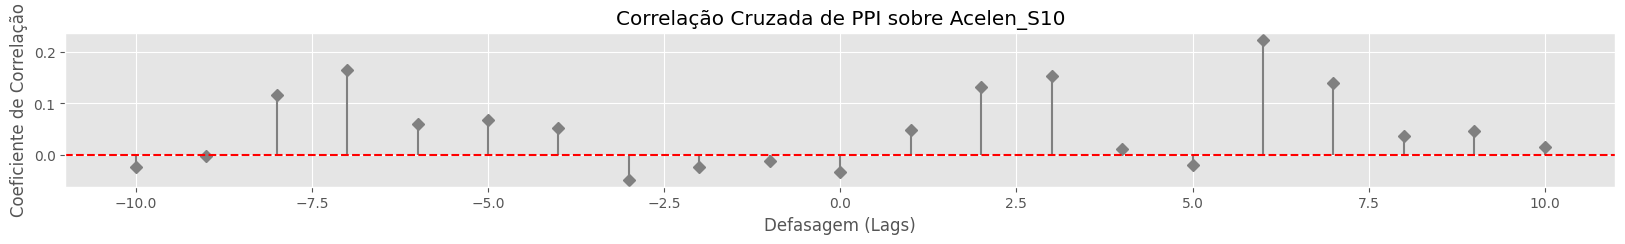

PPI influencia Acelen_S10 nos seguintes períodos: [-8, -7, 2, 3, 6, 7]




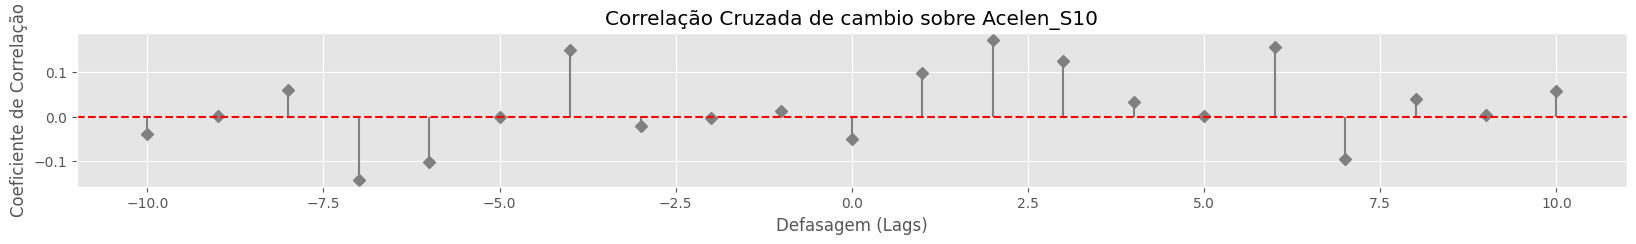

cambio influencia Acelen_S10 nos seguintes períodos: [-7, -6, -4, 2, 3, 6]




In [ ]:
# Diferenciar as séries para alcançar estacionariedade.
data_diff = data[columns_of_interest].diff().dropna()

def cross_correlation(series1, series2, lag=10):
    return [series2.corr(series1.shift(l)) for l in range(-lag, lag+1)]

for col in interference_col:
    correlations = cross_correlation(data_diff[col], data_diff['Acelen_S10'], lag=10)
    lags = np.arange(-10, 11)

    plt.figure(figsize=(20, 2))
    plt.stem(lags, correlations, basefmt=" ", linefmt='grey', markerfmt='D')
    plt.axhline(y=0, color='r', linestyle='--')  # Linha horizontal no zero
    plt.title(f'Correlação Cruzada de {col} sobre Acelen_S10')
    plt.xlabel('Defasagem (Lags)')
    plt.ylabel('Coeficiente de Correlação')
    plt.show()

    significant_lags = [lag for lag, corr in zip(lags, correlations) if abs(corr) > 0.1]
    if significant_lags:
        print(f"{col} influencia Acelen_S10 nos seguintes períodos: {significant_lags}")
    else:
        print(f"Não foram encontradas influências significativas de {col} sobre Acelen_S10.")
    print("\n")


#### `5.1.5 - Executando o teste de cointegração de Johansen`

In [ ]:
model_data = data[columns_of_interest]

# Executando o teste de cointegração de Johansen
coint_test = coint_johansen(model_data, det_order=0, k_ar_diff=1)  # k_ar_diff é a defasagem, det_order=0 significa sem tendência

# Exibindo os resultados do teste de cointegração
print("Trace Statistic:", coint_test.lr1)
print("Critical Values (90%, 95%, 99%):", coint_test.cvt)
print("Eigen Statistics:", coint_test.lr2)
print("Eigenvalues:", coint_test.eig)

print("\nResultados da Análise de Cointegração:")
num_of_vars = len(columns_of_interest) - 1
for i in range(num_of_vars):
    if coint_test.lr1[i] > coint_test.cvt[i, 2]:  # Verificando contra o valor crítico mais conservador (99%)
        involved_vars = ', '.join(columns_of_interest[1:num_of_vars-i+1])  # Listando as variáveis envolvidas
        print(f"Existem {i+1} vetores de cointegração indicando uma relação de longo prazo entre Acelen_S10 e {involved_vars}.")
        for level_idx, level in enumerate(['90%', '95%', '99%']):
            if coint_test.lr1[i] > coint_test.cvt[i, level_idx]:
                print(f"Ao nível de significância de {level}, a hipótese de que existam apenas {i} vetores de cointegração é rejeitada.")
    else:
        print(f"Ao nível de significância de 99%, a hipótese de que existam mais de {i} vetores de cointegração é rejeitada.")

# Checando vetores onde não há cointegração significativa
if all(coint_test.lr1[-1] <= coint_test.cvt[-1, j] for j in range(3)):
    print("Nenhum vetor de cointegração significativo foi encontrado para o número máximo de relações ao nível de 90%, 95% e 99%.")

Trace Statistic: [115.75044771  52.8700831   20.98998103   6.32647923   1.35271284]
Critical Values (90%, 95%, 99%): [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Eigen Statistics: [62.88036462 31.88010206 14.6635018   4.9737664   1.35271284]
Eigenvalues: [0.2842827  0.15597656 0.07503312 0.0261093  0.00716946]

Resultados da Análise de Cointegração:
Existem 1 vetores de cointegração indicando uma relação de longo prazo entre Acelen_S10 e cambio, Europa, Golfo, PPI.
Ao nível de significância de 90%, a hipótese de que existam apenas 0 vetores de cointegração é rejeitada.
Ao nível de significância de 95%, a hipótese de que existam apenas 0 vetores de cointegração é rejeitada.
Ao nível de significância de 99%, a hipótese de que existam apenas 0 vetores de cointegração é rejeitada.
Ao nível de significância de 99%, a hipótese de que existam mais de 1 vetores de cointegração é rejeitada.
Ao nível de si

#### `5.1.6 - Determinar o lag ideal + Ajustar o modelo VAR com o lag ideal`

<class 'statsmodels.iolib.table.SimpleTable'>

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Jul, 2024
Time:                     15:47:39
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    36.6542
Nobs:                     188.000    HQIC:                   36.0910
Log likelihood:          -4635.29    FPE:                3.21960e+15
AIC:                      35.7074    Det(Omega_mle):     2.42284e+15
--------------------------------------------------------------------
Results for equation Acelen_S10
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const               -38.427630        99.080399           -0.388           0.698
L1.Acelen_S10         0.892068         0.074112           12.037           0.000
L1.cambio             0.218837         0.124902        

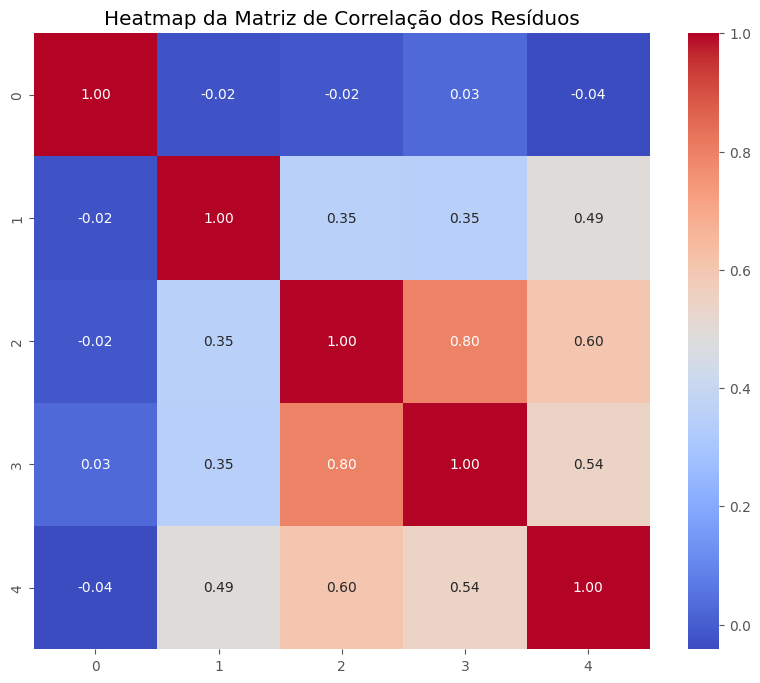

In [ ]:
# Determinar o lag ideal
model = VAR(model_data)
var_model = model.select_order(maxlags=15)
display(var_model.summary())

# Ajustar o modelo VAR com o lag ideal
best_lag = model.select_order(15).aic
var_result = model.fit(best_lag)
display(var_result.summary())

corr_matrix = var_result.resid_corr

# Criar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Heatmap da Matriz de Correlação dos Resíduos')
plt.show()


In [ ]:
# Teste de Dickey-Fuller Aumentado na série diferenciada
adf_result_diff = adfuller(data['Acelen_S10'].dropna())
adf_output_diff = pd.Series(adf_result_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result_diff[4].items():
    adf_output_diff['Critical Value (%s)' % key] = value

adf_output_diff

Test Statistic                  -3.563405
p-value                          0.006500
#Lags Used                      14.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64

In [ ]:
# Configurando e ajustando o modelo VEC
vecm = VECM(model_data, k_ar_diff=1, coint_rank=1)
vecm_fit = vecm.fit()
display(vecm_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation Acelen_S10
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.Acelen_S10     0.0140      0.071      0.196      0.845      -0.126       0.154
L1.cambio         0.2554      0.123      2.080      0.038       0.015       0.496
L1.Europa         0.0421      0.074      0.572      0.567      -0.102       0.186
L1.Golfo         -0.1776      0.075     -2.378      0.017      -0.324      -0.031
L1.PPI            0.0185      0.089      0.208      0.835      -0.155       0.192
Det. terms outside the coint. relation & lagged endog. parameters for equation cambio
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.Acelen_S10     0.0094      0.047      0.199      0.842      -0.083       0.102
L1.cambio        -0.1271      0.081     -1.562      0.118      -0.287       0.032
L1.Europa        -0.0538      0.049     -1.103      0.270      -0.149       0.042
L1.Golfo          0.0699      0.049      1.412      0.158      -0.027       0.167
L1.PPI            0.2119      0.059      3.606      0.000       0.097       0.327
Det. terms outside the coint. relation & lagged endog. parameters for equation Europa
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.Acelen_S10    -0.0655      0.115     -0.570      0.569      -0.291       0.160
L1.cambio        -0.3692      0.198     -1.867      0.062      -0.757       0.018
L1.Europa         0.1465      0.119      1.235      0.217      -0.086       0.379
L1.Golfo          0.0107      0.120      0.089      0.929      -0.225       0.247
L1.PPI            0.2297      0.143      1.608      0.108      -0.050       0.510
Det. terms outside the coint. relation & lagged endog. parameters for equation Golfo
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.Acelen_S10    -0.1214      0.106     -1.146      0.252      -0.329       0.086
L1.cambio        -0.3516      0.182     -1.928      0.054      -0.709       0.006
L1.Europa         0.4789      0.109      4.380      0.000       0.265       0.693
L1.Golfo         -0.2689      0.111     -2.424      0.015      -0.486      -0.051
L1.PPI            0.3466      0.132      2.631      0.009       0.088       0.605
Det. terms outside the coint. relation & lagged endog. parameters for equation PPI
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.Acelen_S10    -0.0042      0.066     -0.065      0.948      -0.133       0.124
L1.cambio        -0.2862      0.113     -2.538      0.011      -0.507      -0.065
L1.Europa         0.0723      0.068      1.069      0.285      -0.060       0.205
L1.Golfo         -0.0096      0.069     -0.140      0.888      -0.144       0.125
L1.PPI            0.3210      0.081      3.940      0.000       0.161       0.481
             Loading coefficients (alpha) for equation Acelen_S10             
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

#### `5.1.7 Augmented Dickey-Fuller Test (Stationarity Test)`

Results of Dickey-Fuller Test for Acelen_S10:
Test Statistic           -2.452652
p-value                   0.127424
Lags Used                 9.000000
Observations Used       180.000000
Critical Value (1%)      -3.467211
Critical Value (5%)      -2.877735
Critical Value (10%)     -2.575403
dtype: float64



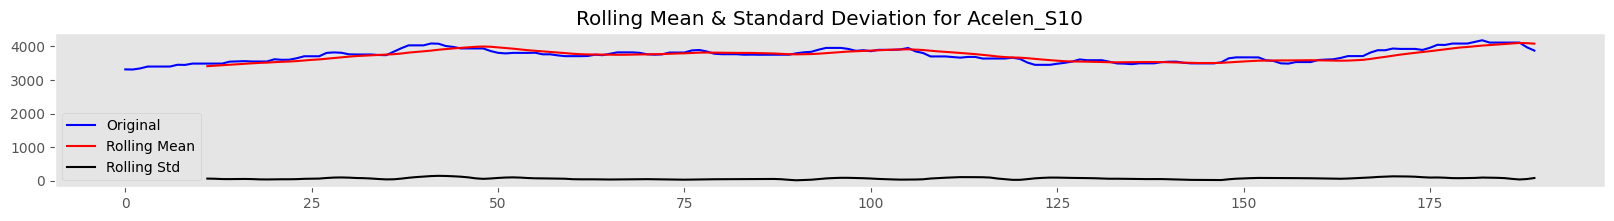

Results of Dickey-Fuller Test for cambio:
Test Statistic           -2.452652
p-value                   0.127424
Lags Used                 9.000000
Observations Used       180.000000
Critical Value (1%)      -3.467211
Critical Value (5%)      -2.877735
Critical Value (10%)     -2.575403
dtype: float64



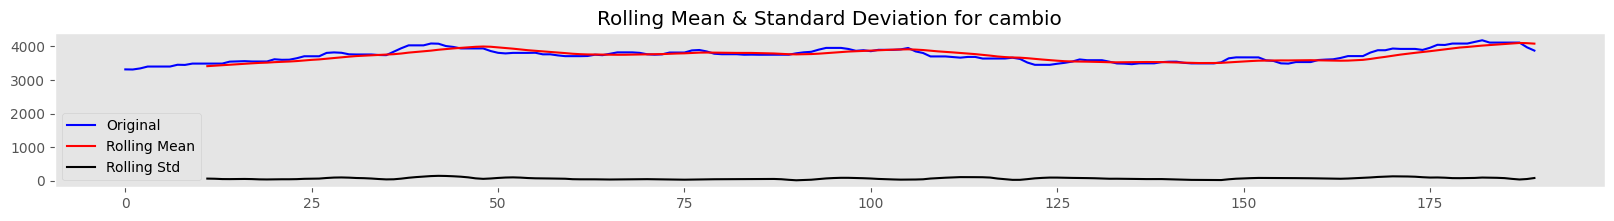

Results of Dickey-Fuller Test for Europa:
Test Statistic           -2.452652
p-value                   0.127424
Lags Used                 9.000000
Observations Used       180.000000
Critical Value (1%)      -3.467211
Critical Value (5%)      -2.877735
Critical Value (10%)     -2.575403
dtype: float64



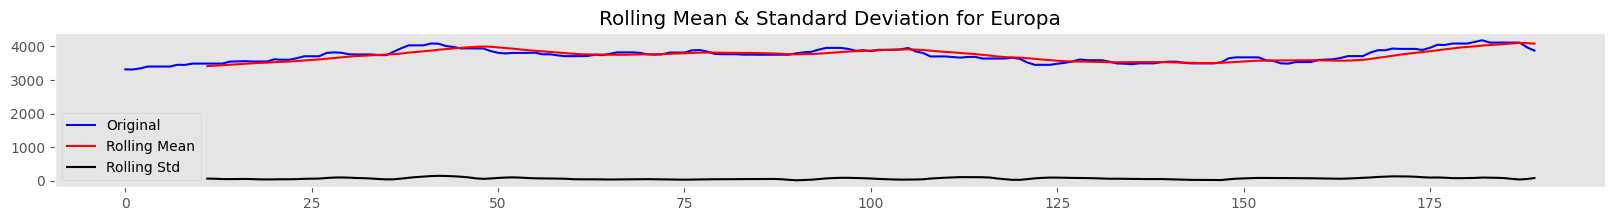

Results of Dickey-Fuller Test for Golfo:
Test Statistic           -2.452652
p-value                   0.127424
Lags Used                 9.000000
Observations Used       180.000000
Critical Value (1%)      -3.467211
Critical Value (5%)      -2.877735
Critical Value (10%)     -2.575403
dtype: float64



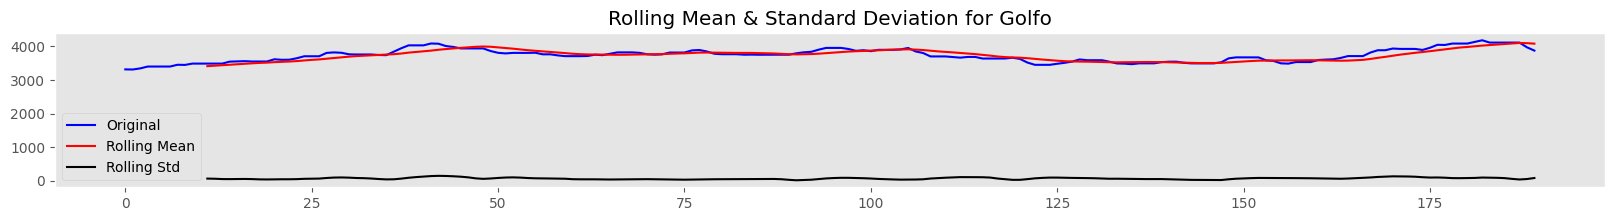

Results of Dickey-Fuller Test for PPI:
Test Statistic           -2.452652
p-value                   0.127424
Lags Used                 9.000000
Observations Used       180.000000
Critical Value (1%)      -3.467211
Critical Value (5%)      -2.877735
Critical Value (10%)     -2.575403
dtype: float64



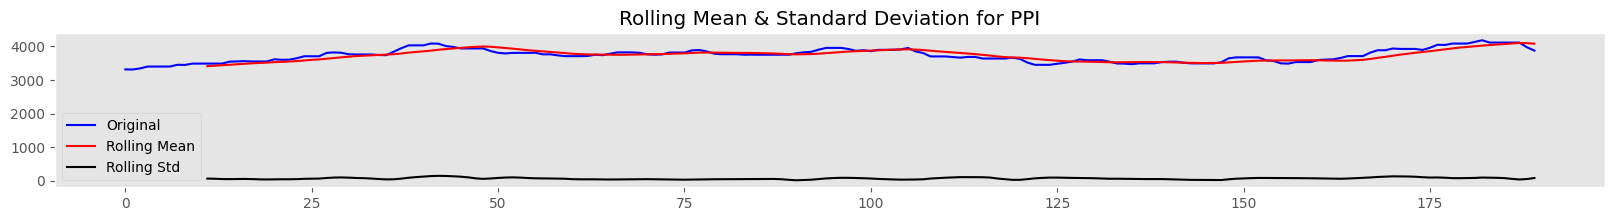

In [ ]:
# Função para realizar o teste Dickey-Fuller e plotar estatísticas de rolamento
def dftest(timeseries, category_name):
    # Realizar o teste Dickey-Fuller
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(f'Results of Dickey-Fuller Test for {category_name}:\n{dfoutput}\n')

    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plotar estatísticas de rolamento
    fig, ax = plt.subplots(figsize=(20, 2))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for {category_name}')
    plt.grid()
    plt.show()

for col in columns_of_interest:
    dftest(col_sales, col)


#### `5.1.8 - Função para calcular a causalidade de Granger`

Cause      Effect          P-values  Best Lag
0       cambio  Acelen_S10  [0.0392, 0.0828]         2
1       cambio      Europa  [0.7954, 0.4245]         2
2       cambio       Golfo   [0.872, 0.9429]         2
3       cambio         PPI  [0.8387, 0.0219]         2
4       Europa  Acelen_S10     [0.0, 0.0001]         2
5       Europa      cambio   [0.186, 0.4671]         2
6       Europa       Golfo     [0.0064, 0.0]         2
7       Europa         PPI  [0.0001, 0.0077]         2
8        Golfo  Acelen_S10  [0.0004, 0.0004]         2
9        Golfo      cambio  [0.3636, 0.5482]         2
10       Golfo      Europa  [0.8161, 0.6371]         2
11       Golfo         PPI     [0.0, 0.0007]         2
12         PPI  Acelen_S10  [0.0004, 0.0017]         2
13         PPI      cambio  [0.8185, 0.0093]         2
14         PPI      Europa  [0.7235, 0.1896]         2
15         PPI       Golfo  [0.0687, 0.0001]         2
16  Acelen_S10      cambio  [0.0762, 0.1964]         2
17  Acelen_S10      Europa  [0.7552, 0.7351]         2
18  Acelen_S10       Golfo  [0.8434, 0.3592]         2
19  Acelen_S10         PPI  [0.3136, 0.9303]         2

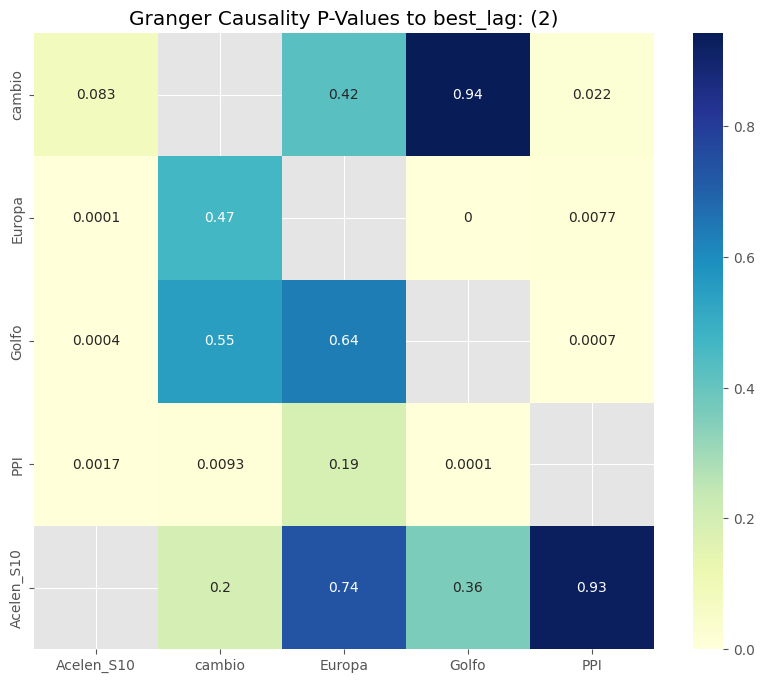

In [ ]:
# Função para calcular a causalidade de Granger
def granger_causality(data, max_lag):
    results = {}
    for col in data.columns:
        results[col] = {}
        for target in data.columns:
            if col != target:
                test_result = grangercausalitytests(data[[col, target]], max_lag, verbose=False)
                p_values = [round(test_result[i+1][0]['ssr_chi2test'][1], 4) for i in range(max_lag)]
                results[col][target] = p_values
    return results

# Aplicar testes de causalidade Granger
granger_results = granger_causality(data.iloc[:, 1:], max_lag=best_lag)

# Transformar a saída em um DataFrame
granger_df = pd.DataFrame(granger_results).stack().reset_index()
granger_df.columns = ['Cause', 'Effect', 'P-values']
granger_df['Best Lag'] = granger_df['P-values'].apply(lambda x: len(x))
granger_df['P-values'] = granger_df['P-values'].apply(lambda x: np.array(x))

display(granger_df)

def create_heatmap_data(results, lag):
    heatmap_data = {}
    for key in results.keys():
        heatmap_data[key] = {subkey: results[key][subkey][best_lag-1] for subkey in results[key].keys()}
    return pd.DataFrame(heatmap_data)

# Criar dados para heatmap usando o best_lag (ajuste conforme necessário)
heatmap_data = create_heatmap_data(granger_results, best_lag)

# Plotar a matriz de calor dos p-values
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True)
plt.title(f"Granger Causality P-Values to best_lag: ({best_lag})")
plt.show()

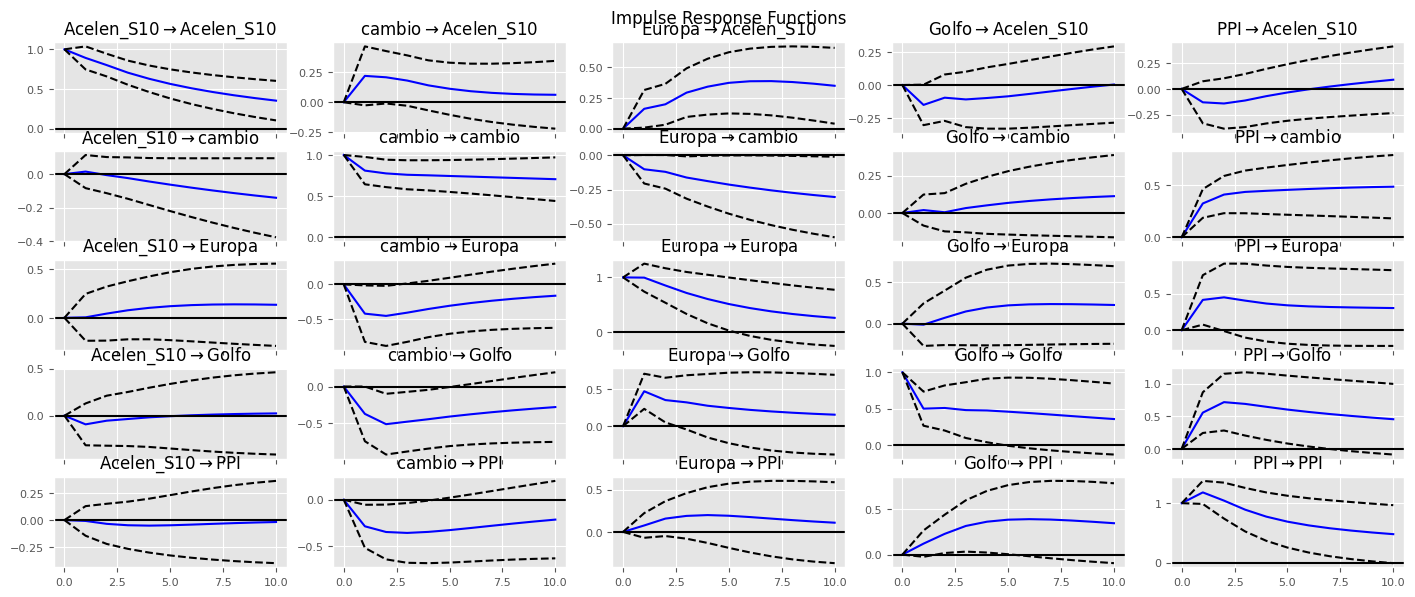

In [ ]:
# Gerar funções de resposta ao impulso (IRFs)
irf = var_result.irf(10)

# Plotar IRFs com ajustes diretos de tamanho de figura e fonte
irf_plot = irf.plot(orth=False, figsize=(15, 6))
irf_plot.suptitle('Impulse Response Functions', fontsize=12)

# Ajustar tamanhos de fonte nos subplots
for i in range(len(irf_plot.axes)):
    for tick in irf_plot.axes[i].get_xticklabels() + irf_plot.axes[i].get_yticklabels():
        tick.set_fontsize(8)

# Plotar os efeitos cumulativos dos IRFs com ajustes similares
# irf_cum_plot = irf.plot_cum_effects(orth=False, figsize=(15, 6))
# irf_cum_plot.suptitle('Cumulative Effects of Impulse Responses', fontsize=12)

# for i in range(len(irf_cum_plot.axes)):
#     for tick in irf_cum_plot.axes[i].get_xticklabels() + irf_cum_plot.axes[i].get_yticklabels():
#         tick.set_fontsize(8)

plt.show()

#### `5.1.9 - Função de média móvel ajustada`

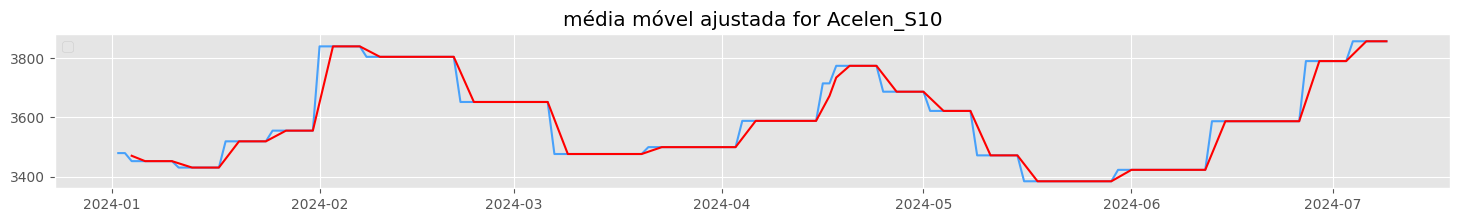

Mean Square Error for Acelen_S10: 859.6268321514016



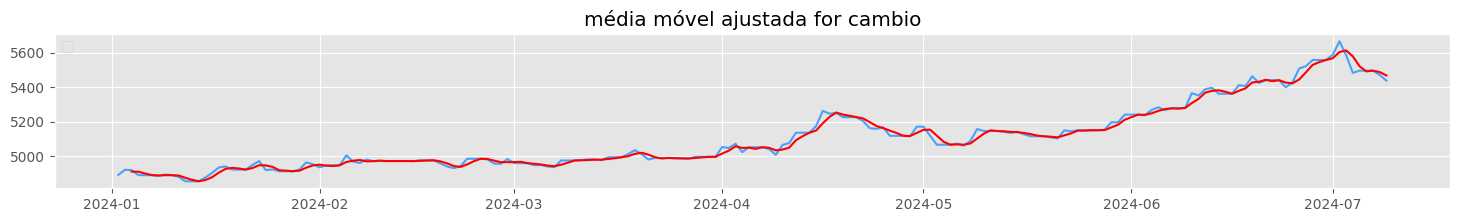

Mean Square Error for cambio: 398.5549054374377



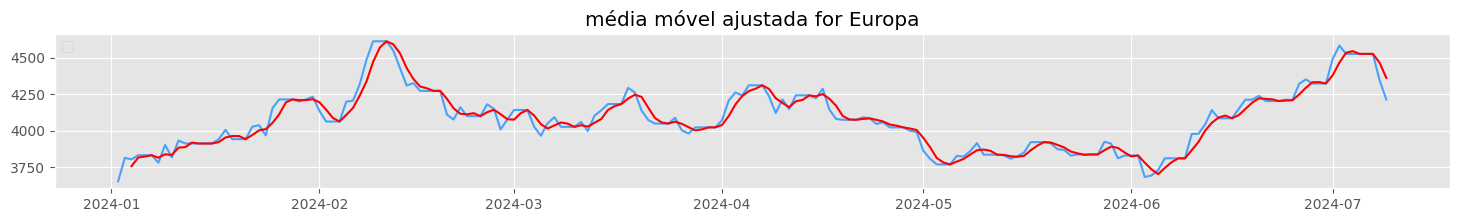

Mean Square Error for Europa: 2392.2527346332326



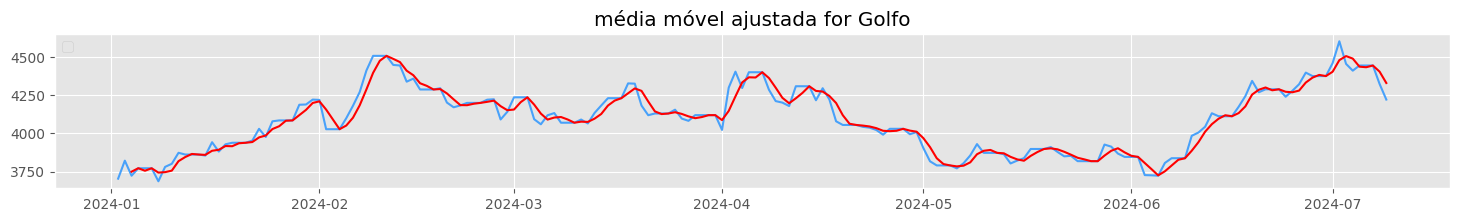

Mean Square Error for Golfo: 2251.803274586239



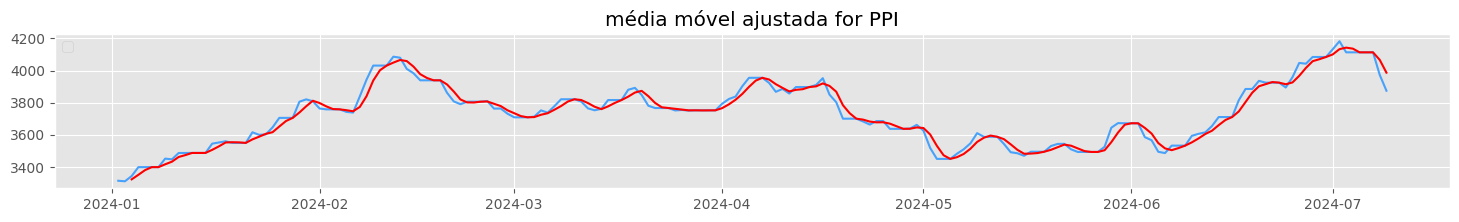

Mean Square Error for PPI: 1122.8169189716232



In [ ]:
# Função de média móvel ajustada
def moving_average(observations, window=3):
    if len(observations) < window:
        return np.array([np.nan]*len(observations))  # Retorna um array de NaNs se não houver dados suficientes
    cumulative_sum = np.cumsum(observations)
    moving_avg = np.empty(len(observations))
    moving_avg[:window-1] = np.nan  # Preenchendo as primeiras posições com NaN
    moving_avg[window-1:] = (cumulative_sum[window-1:] - np.concatenate(([0], cumulative_sum[:-window]))) / window
    return moving_avg

# Preparação dos dados
data['Date'] = pd.to_datetime(data['Date'])  # Assegurar que a coluna Date é tratada como datetime
columns_of_interest = ['Acelen_S10', 'cambio', 'Europa', 'Golfo', 'PPI']

# Loop para processar cada coluna de interesse
for col in columns_of_interest:
    sales_data = data[col]  # Usando coluna direto
    sales_mov_avg = moving_average(sales_data, window=3)

    # Inserir média nas primeiras posições não é mais necessário graças ao preenchimento com NaN
    data[col + '_mov_avg'] = sales_mov_avg

    # Plotagem dos dados
    fig, ax = plt.subplots(figsize=(18, 2))
    ax.plot(data['Date'], data[col], c='#48A1FA')
    ax.plot(data['Date'], data[col + '_mov_avg'], c='red')
    plt.legend([f'{col} Values', f'{col} Moving Average'])
    plt.legend(loc='upper left')
    plt.title(f"média móvel ajustada for {col}")
    plt.show()

    # Cálculo do MSE
    valid_mask = ~np.isnan(sales_mov_avg)  # Mascara para excluir NaNs no cálculo do MSE
    mse_value = mse(sales_data[valid_mask], sales_mov_avg[valid_mask])
    print(f"Mean Square Error for {col}: {mse_value}\n")

    data.drop([col + '_mov_avg'], axis=1, inplace=True)  # Limpar a coluna extra


### `6 - Simulations and Models`

#### `6.1 - Simple Smoothing`

MSE for Acelen_S10:  29715.823384000007


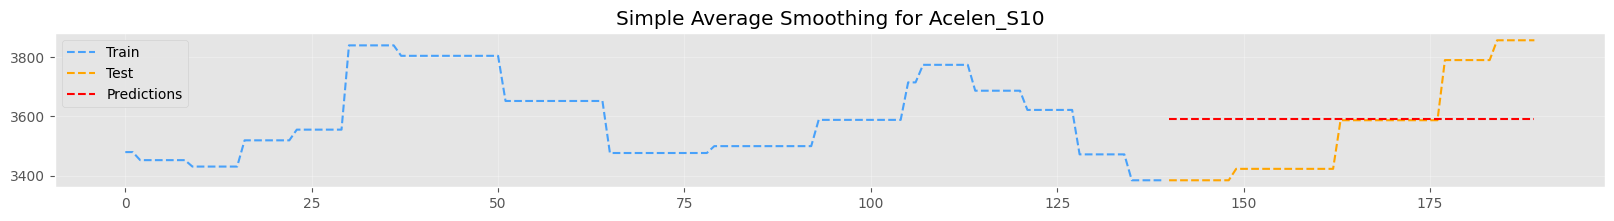

MSE for cambio:  141368.13750500002


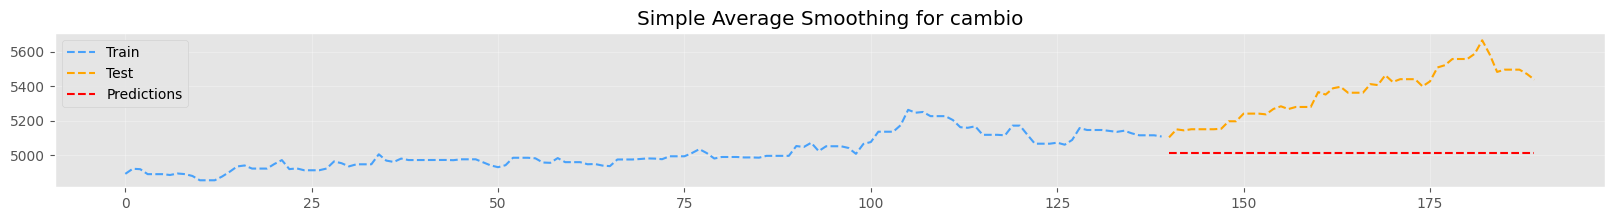

MSE for Europa:  67852.10222480004


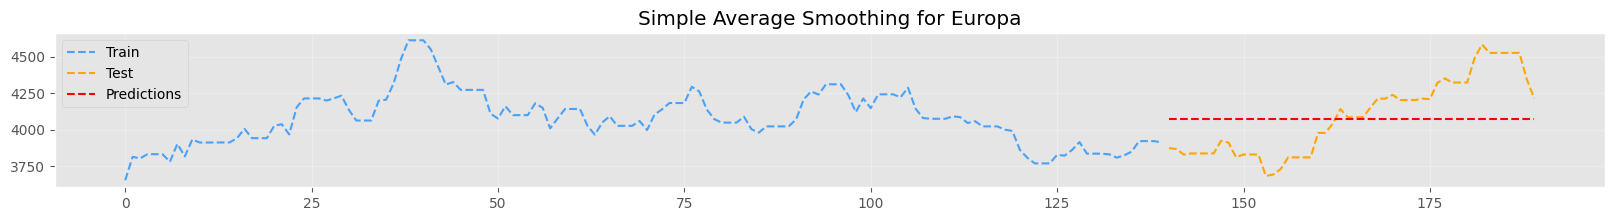

MSE for Golfo:  65089.84005200001


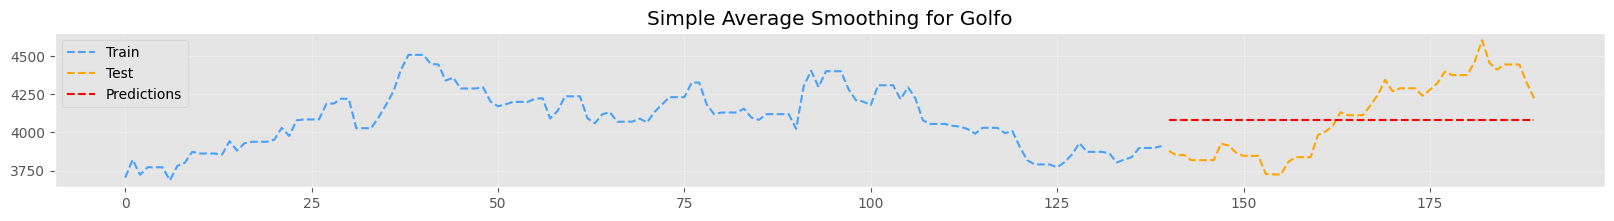

MSE for PPI:  57365.29399540005


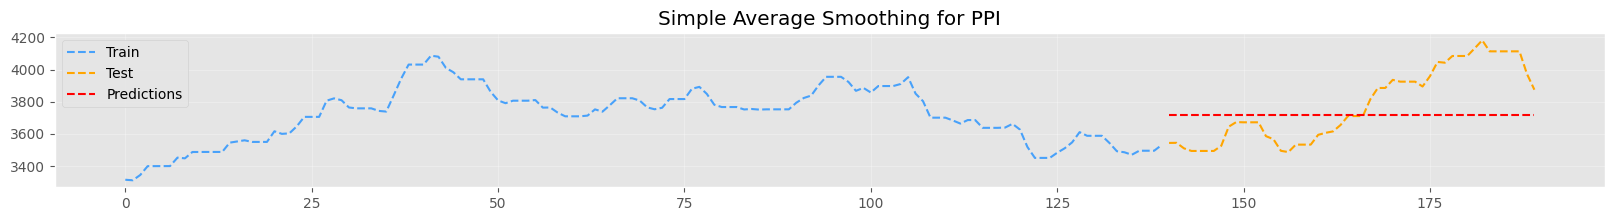

In [ ]:
# Função para treinar e testar o modelo
def train_test_model(data, column):
    col_prices = data[column].dropna()  # Remove valores NaN se houver

    train = col_prices[:-50]
    test = col_prices[-50:]
    train_time = col_prices.index[:-50]
    test_time = col_prices.index[-50:]
    trend_seasonal_avg = np.mean(train)
    simple_avg_preds = np.round(np.full(shape=len(test), fill_value=trend_seasonal_avg, dtype='float'), 3)
    simple_mse = mean_squared_error(test.values, simple_avg_preds)

    print(f"MSE for {column}: ", simple_mse)

    # Display the first 10 actual vs predictions
    # display(pd.DataFrame({'Actual': test.values, 'Predictions': simple_avg_preds}).head(10))

    # Plotting
    fig, ax = plt.subplots(figsize=(20, 2))
    plt.plot(train_time, train.values, '#48A1FA', linestyle="--", label="Train")
    plt.plot(test_time, test.values, color='orange', linestyle="--", label="Test")
    plt.plot(test_time, simple_avg_preds, 'r--', label="Predictions")
    plt.legend(loc='upper left')
    plt.title(f"Simple Average Smoothing for {column}")
    plt.grid(alpha=0.3)
    plt.show()

# Iteração sobre as colunas de interesse
for column in columns_of_interest:
    train_test_model(data, column)

#### `6.2 - Exponential Smoothing`

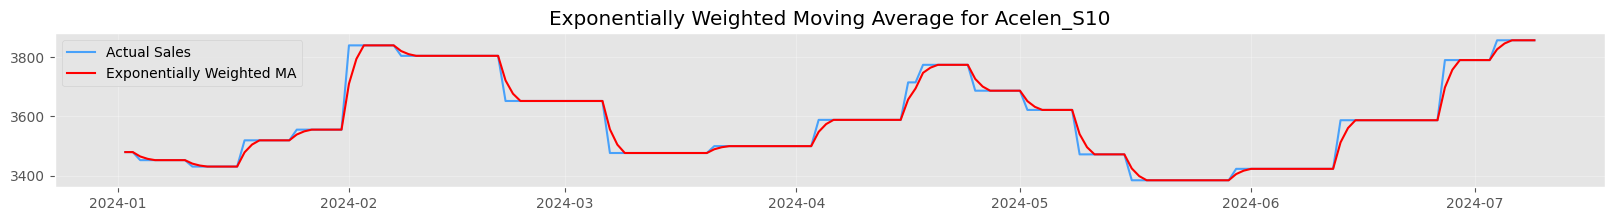

Mean Square Error for Acelen_S10: 356.905



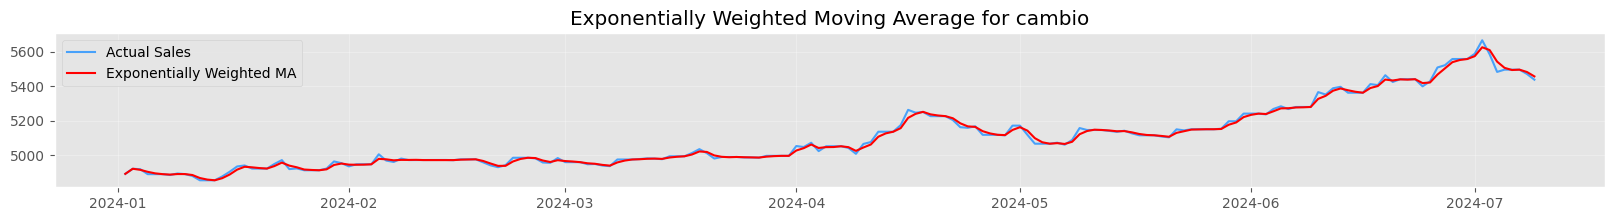

Mean Square Error for cambio: 164.997



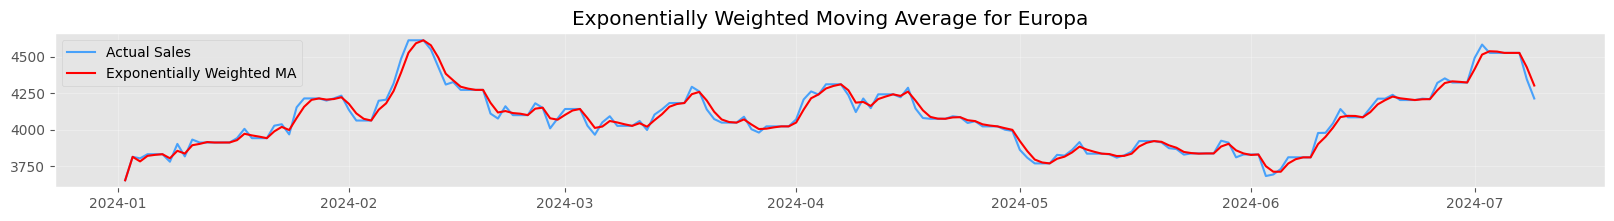

Mean Square Error for Europa: 975.683



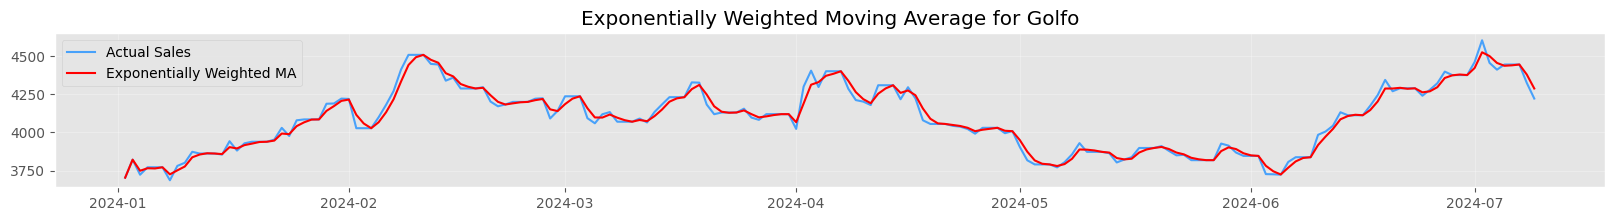

Mean Square Error for Golfo: 928.015



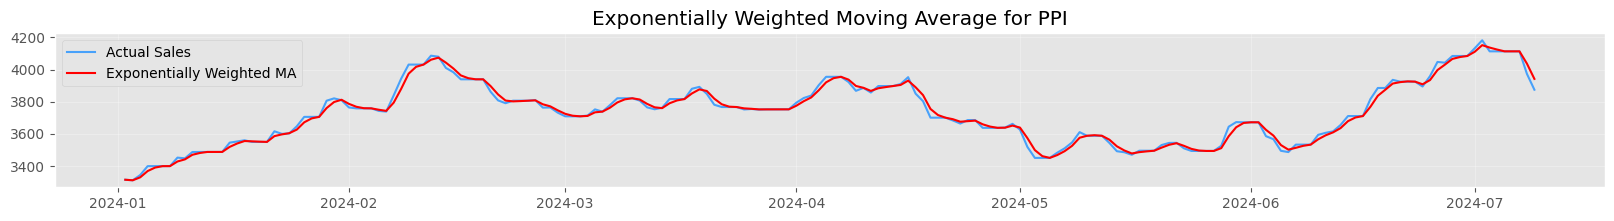

Mean Square Error for PPI: 445.353



In [ ]:
def ewma(observations, forecast=True):
    '''retorna a versão suavizada exponencialmente ponderada de um array de observações.'''
    weights = np.array([0.160, 0.294, 0.543])
    normalized_weights = weights / np.sum(weights)

    output = np.zeros_like(observations, dtype='float')
    mean = np.mean(observations)  # A média é calculada uma vez só, fora do loop

    for i in range(2, len(observations)):  # Ajuste do loop para começar de 2
        output[i] = np.dot(normalized_weights, observations[i-2:i+1])

    if forecast:
        output[:2] = mean  # Preenche os primeiros dois valores com a média, se forecast é True
    else:
        output[:2] = observations[:2]  # Mantém os valores originais nos primeiros dois pontos

    return output

# Iteração sobre as colunas de interesse
columns_of_interest = ['Acelen_S10', 'cambio', 'Europa', 'Golfo', 'PPI']
for column in columns_of_interest:
    sales_data = data[column].dropna()  # Usando coluna diretamente e removendo NaN
    ewma_smoothed_vals = ewma(sales_data, forecast=False)

    # Criar DataFrame para plotagem
    date_index = data['Date'][sales_data.index]  # Assegurar o uso correto do índice de datas
    plot_data = pd.DataFrame({'SALES': sales_data.values, 'SALES_exp': ewma_smoothed_vals}, index=date_index)

    # Plotagem dos dados
    fig, ax = plt.subplots(figsize=(20, 2))
    ax.plot(plot_data.index, plot_data['SALES'], c='#48A1FA', label='Actual Sales')
    ax.plot(plot_data.index, plot_data['SALES_exp'], c='red', label='Exponentially Weighted MA')
    ax.legend(loc='upper left')
    ax.set_title(f"Exponentially Weighted Moving Average for {column}")
    ax.grid(alpha=0.3)
    plt.show()

    # Cálculo do MSE
    mse_value = mean_squared_error(plot_data['SALES'], plot_data['SALES_exp'])
    print(f"Mean Square Error for {column}: {mse_value:.3f}\n")


#### `6.3 - Forecasting by smoothing techniques`


##### `A. simple average`

MSE for Acelen_S10:  29715.823384000007


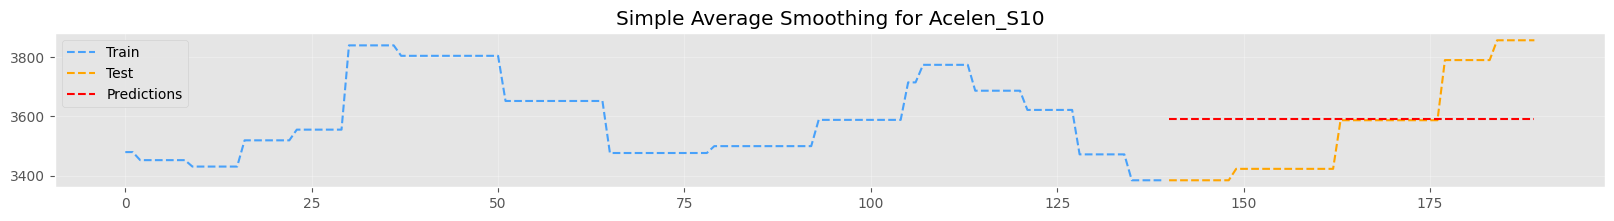

MSE for cambio:  141368.13750500002


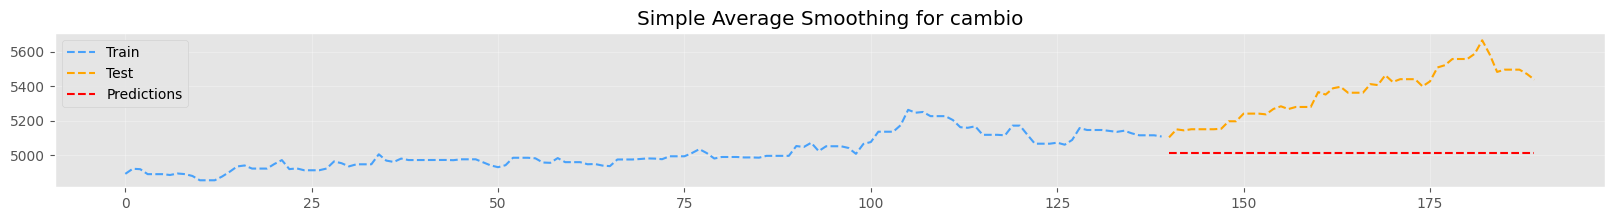

MSE for Europa:  67852.10222480004


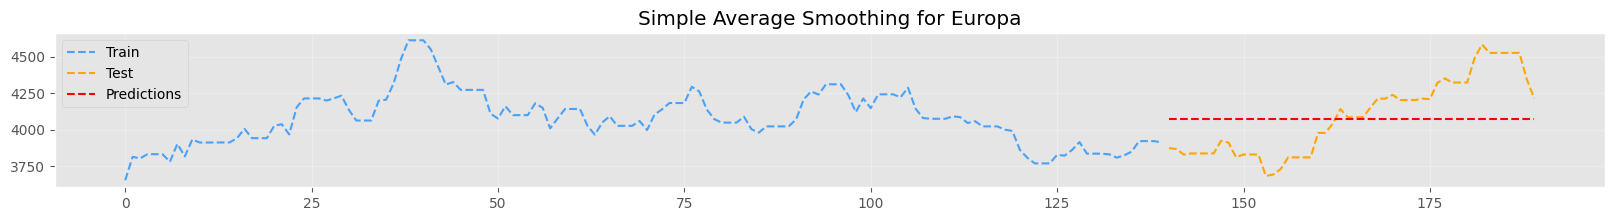

MSE for Golfo:  65089.84005200001


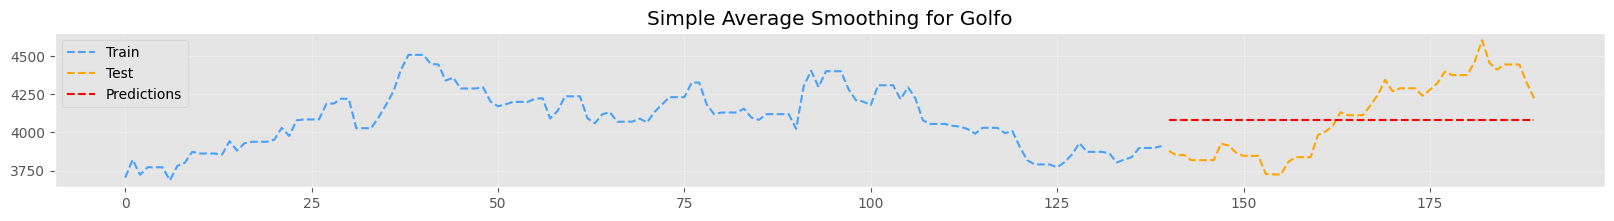

MSE for PPI:  57365.29399540005


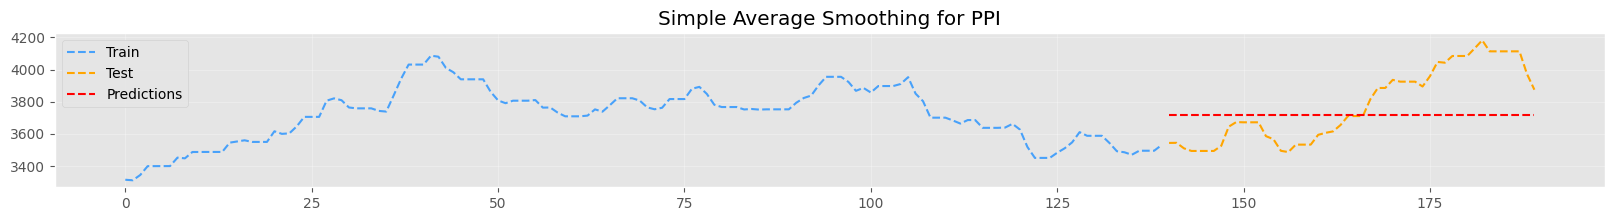

In [ ]:
# Função para treinar e testar o modelo
def train_test_model(data, column):
    col_prices = data[column].dropna()  # Remove valores NaN se houver

    train = col_prices[:-50]
    test = col_prices[-50:]
    train_time = col_prices.index[:-50]
    test_time = col_prices.index[-50:]
    trend_seasonal_avg = np.mean(train)
    simple_avg_preds = np.round(np.full(shape=len(test), fill_value=trend_seasonal_avg, dtype='float'), 3)
    simple_mse = mean_squared_error(test.values, simple_avg_preds)

    print(f"MSE for {column}: ", simple_mse)

    # Display the first 10 actual vs predictions
    # display(pd.DataFrame({'Actual': test.values, 'Predictions': simple_avg_preds}).head(10))

    # Plotting
    fig, ax = plt.subplots(figsize=(20, 2))
    plt.plot(train_time, train.values, '#48A1FA', linestyle="--", label="Train")
    plt.plot(test_time, test.values, color='orange', linestyle="--", label="Test")
    plt.plot(test_time, simple_avg_preds, 'r--', label="Predictions")
    plt.legend(loc='upper left')
    plt.title(f"Simple Average Smoothing for {column}")
    plt.grid(alpha=0.3)
    plt.show()

# Iteração sobre as colunas de interesse
for column in columns_of_interest:
    train_test_model(data, column)

##### `B. Single Exponential`

MSE for Acelen_S10: 61823.438


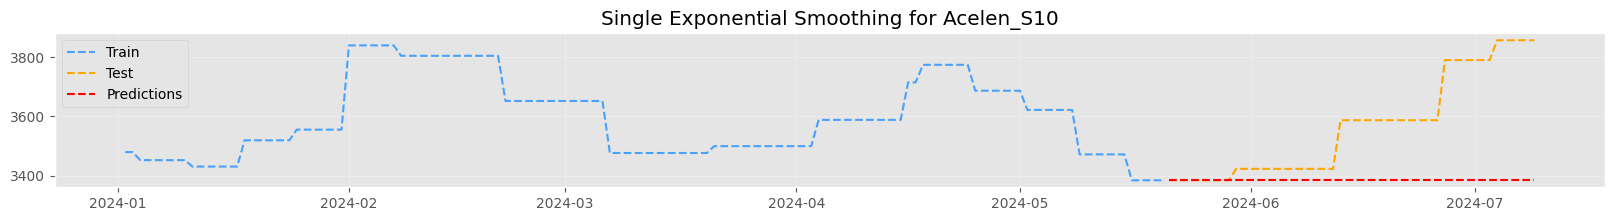

MSE for cambio: 84579.966


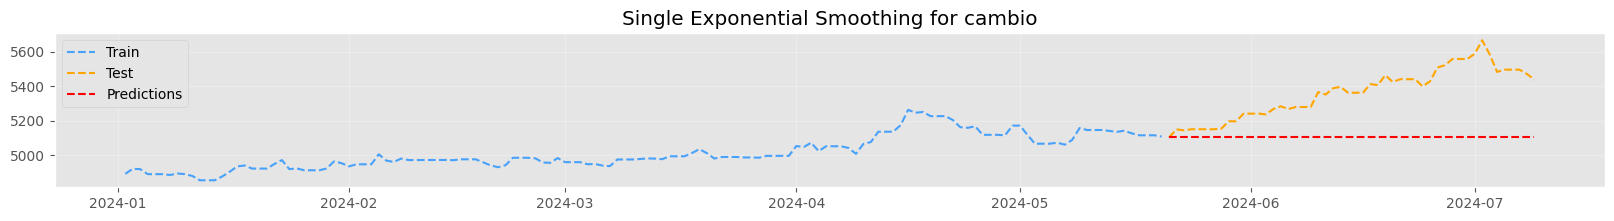

MSE for Europa: 99010.057


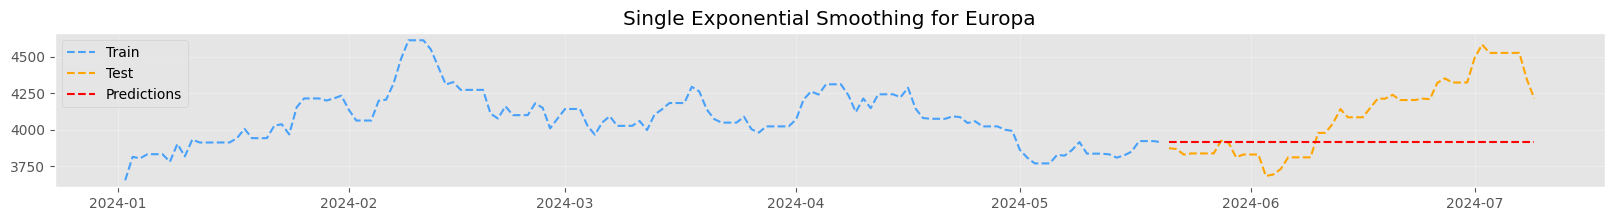

MSE for Golfo: 102323.004


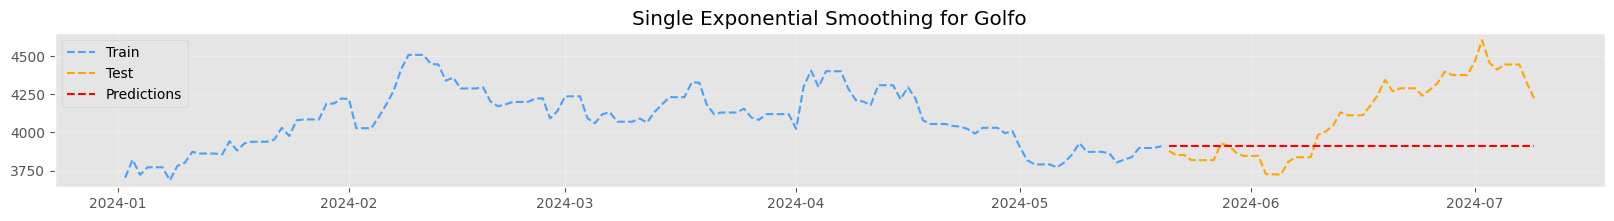

MSE for PPI: 115231.956


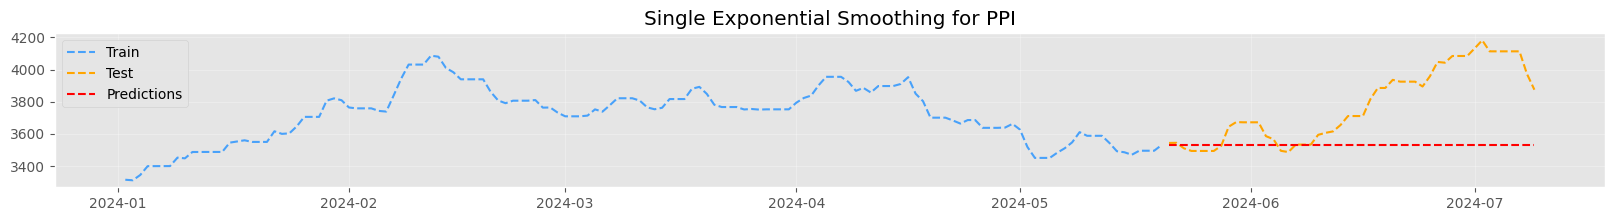

In [ ]:
# Iteração sobre as colunas de interesse
for column in columns_of_interest:
    col_data = data[[column, 'Date']].dropna()  # Remover valores NaN e garantir que temos a data

    # Dividindo os dados em treino e teste
    train = col_data[column][:-50]
    test = col_data[column][-50:]
    train_time = col_data['Date'][:-50]
    test_time = col_data['Date'][-50:]

    # Aplicando suavização exponencial simples
    model = SimpleExpSmoothing(train).fit(optimized=True)
    predictions = model.forecast(len(test))
    predictions_rounded = np.round(predictions, 3)

    # Calculando o erro quadrático médio (MSE)
    mse_value = mean_squared_error(test, predictions_rounded)

    # Mostrando os primeiros 10 valores reais vs previsões
    comparison_df = pd.DataFrame({'Actual': test.values, 'Predictions': predictions_rounded}, index=test_time)
    # print(comparison_df.head(10))
    print(f"MSE for {column}: {mse_value:.3f}")

    # Plotagem dos resultados
    fig, ax = plt.subplots(figsize=(20, 2))
    ax.plot(train_time, train, '#48A1FA', linestyle="--", label="Train")
    ax.plot(test_time, test, color='orange', linestyle="--", label="Test")
    ax.plot(test_time, predictions_rounded, 'r--', label="Predictions")
    ax.legend(loc='upper left')
    ax.set_title(f"Single Exponential Smoothing for {column}")
    ax.grid(alpha=0.3)
    plt.show()


##### `C. Double Exponential`

MSE for Acelen_S10: 61957.764


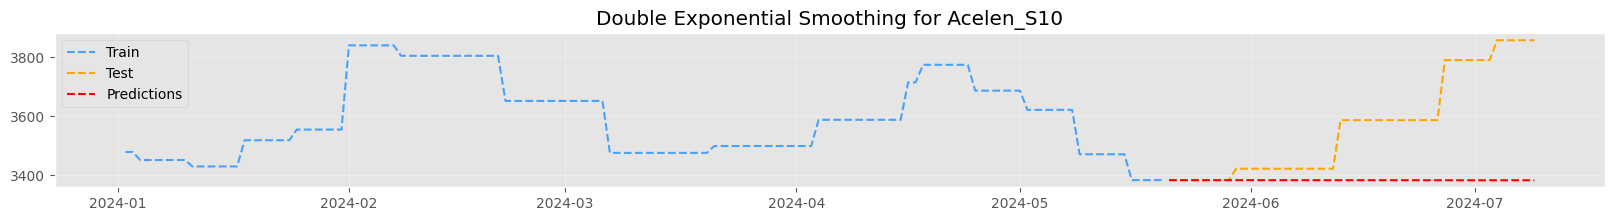

MSE for cambio: 111251.226


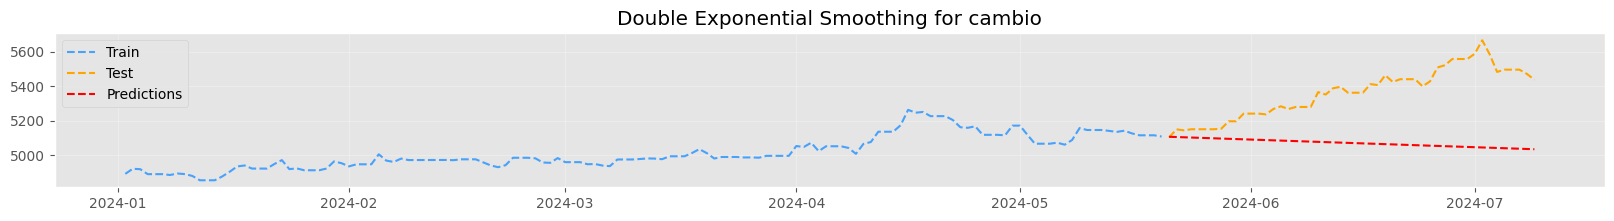

MSE for Europa: 31951.581


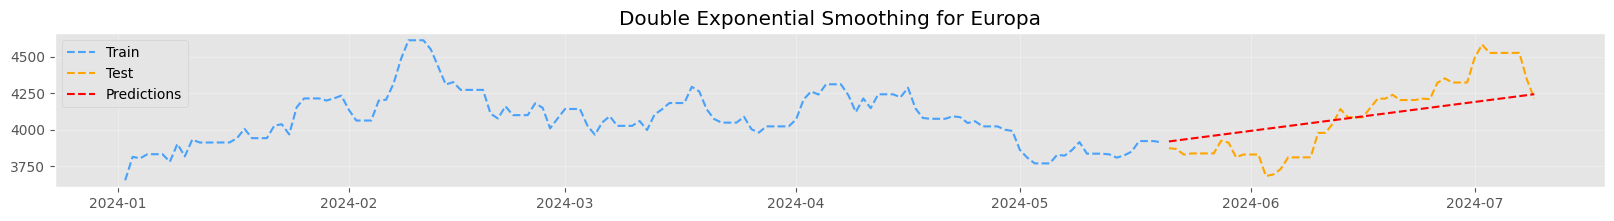

MSE for Golfo: 50578.828


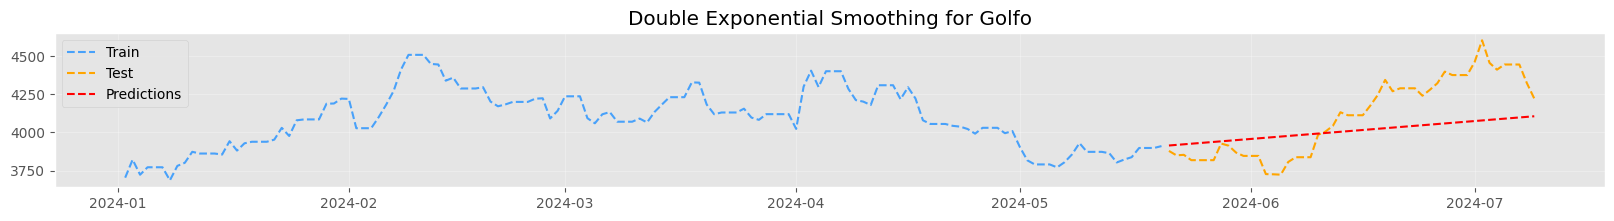

MSE for PPI: 205778.403


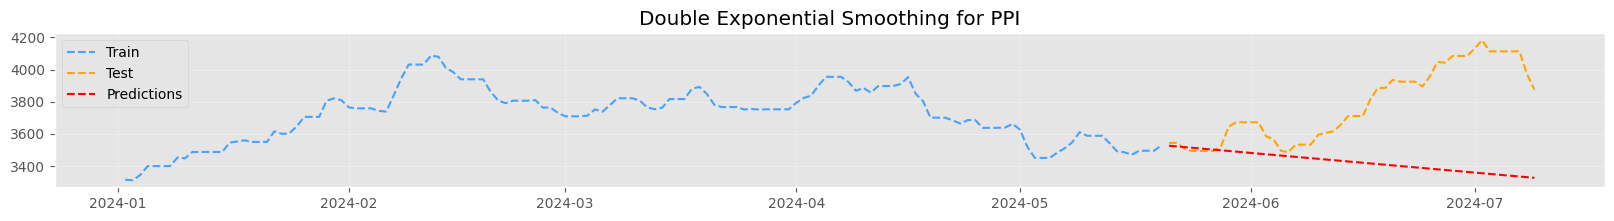

In [ ]:
# Iteração sobre as colunas de interesse
for column in columns_of_interest:
    col_data = data[[column, 'Date']].dropna()  # Remover valores NaN e garantir que temos a data

    # Dividindo os dados em treino e teste
    train = col_data[column][:-50]
    test = col_data[column][-50:]
    train_time = col_data['Date'][:-50]
    test_time = col_data['Date'][-50:]

    # Aplicando suavização exponencial dupla
    model = Holt(train).fit(optimized=True)
    predictions = model.forecast(len(test))

    # Calculando o erro quadrático médio (MSE)
    mse_value = mean_squared_error(test, predictions)

    # Mostrando os primeiros 10 valores reais vs previsões
    comparison_df = pd.DataFrame({'Actual': test.values, 'Predictions': predictions}, index=test_time)
    # print(comparison_df.head(10))
    print(f"MSE for {column}: {mse_value:.3f}")

    # Plotagem dos resultados
    fig, ax = plt.subplots(figsize=(20, 2))
    ax.plot(train_time, train, '#48A1FA', linestyle="--", label="Train")
    ax.plot(test_time, test, color='orange', linestyle="--", label="Test")
    ax.plot(test_time, predictions, 'r--', label="Predictions")
    ax.legend(loc='upper left')
    ax.set_title(f"Double Exponential Smoothing for {column}")
    ax.grid(alpha=0.3)
    plt.show()


##### `D. Triple Exponential`

MSE for Acelen_S10: 88928.324


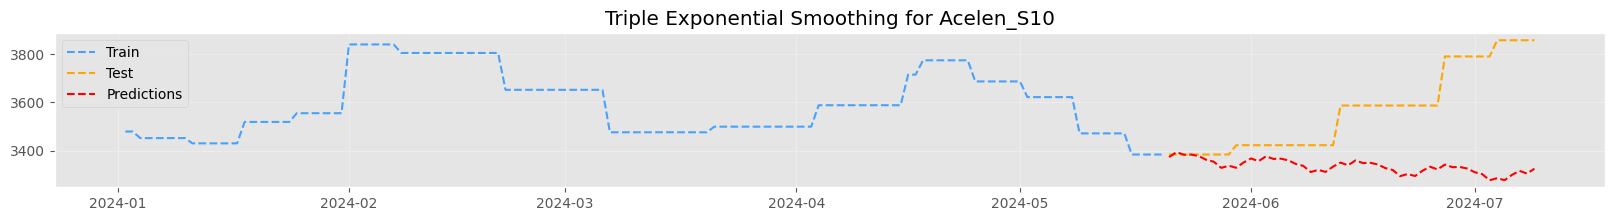

MSE for cambio: 58897.754


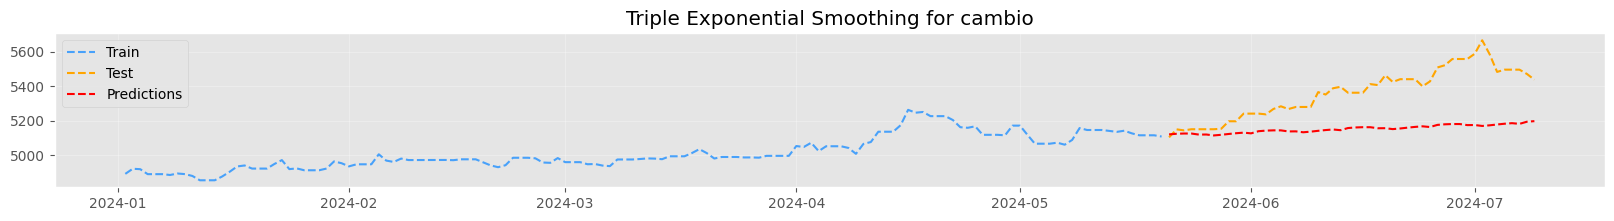

MSE for Europa: 134502.407


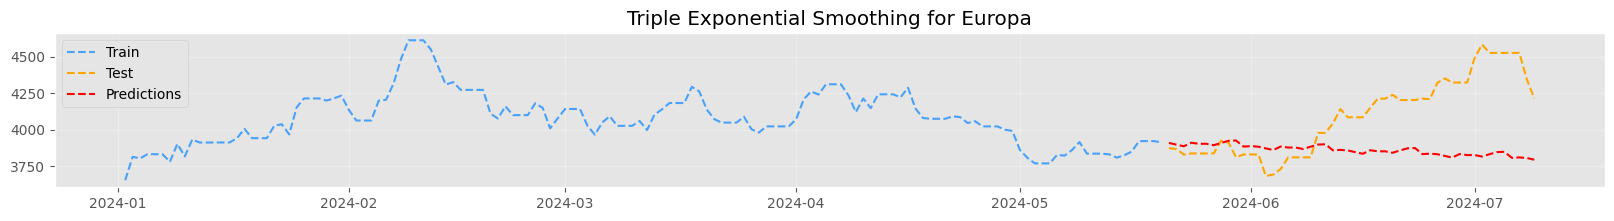

MSE for Golfo: 166709.519


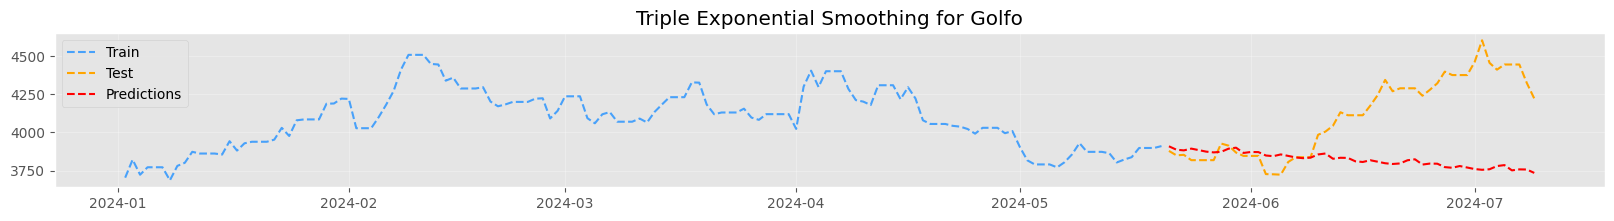

MSE for PPI: 231092.146


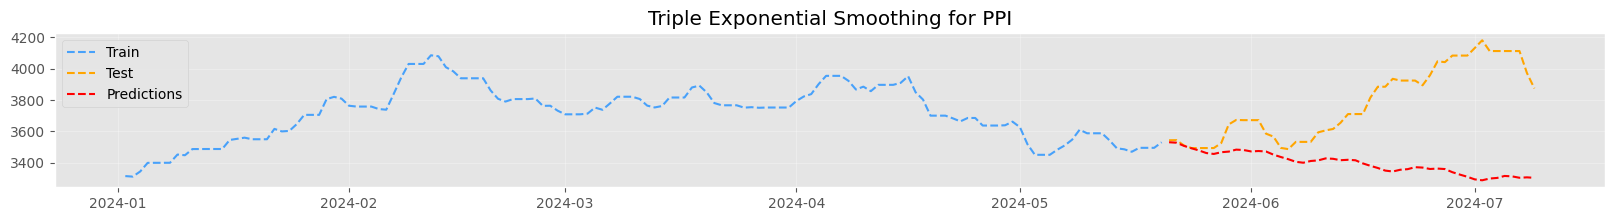

In [ ]:
# Iteração sobre as colunas de interesse
for column in columns_of_interest:
    col_data = data[[column, 'Date']].dropna()  # Remover valores NaN e garantir que temos a data

    # Dividindo os dados em treino e teste
    train = col_data[column][:-50]
    test = col_data[column][-50:]
    train_time = col_data['Date'][:-50]
    test_time = col_data['Date'][-50:]

    # Aplicando suavização exponencial tripla
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)
    predictions = model.forecast(len(test))

    # Calculando o erro quadrático médio (MSE)
    mse_value = mean_squared_error(test, predictions)

    # Mostrando os primeiros 10 valores reais vs previsões
    comparison_df = pd.DataFrame({'Actual': test.values, 'Predictions': predictions}, index=test_time)
    # print(comparison_df.head(10))
    print(f"MSE for {column}: {mse_value:.3f}")

    # Plotagem dos resultados
    fig, ax = plt.subplots(figsize=(20, 2))
    ax.plot(train_time, train, '#48A1FA', linestyle="--", label="Train")
    ax.plot(test_time, test, color='orange', linestyle="--", label="Test")
    ax.plot(test_time, predictions, 'r--', label="Predictions")
    ax.legend(loc='upper left')
    ax.set_title(f"Triple Exponential Smoothing for {column}")
    ax.grid(alpha=0.3)
    plt.show()


##### `E. Análise de Séries Temporais: Simple, Holt e Exponential Smoothing com Statsmodels`

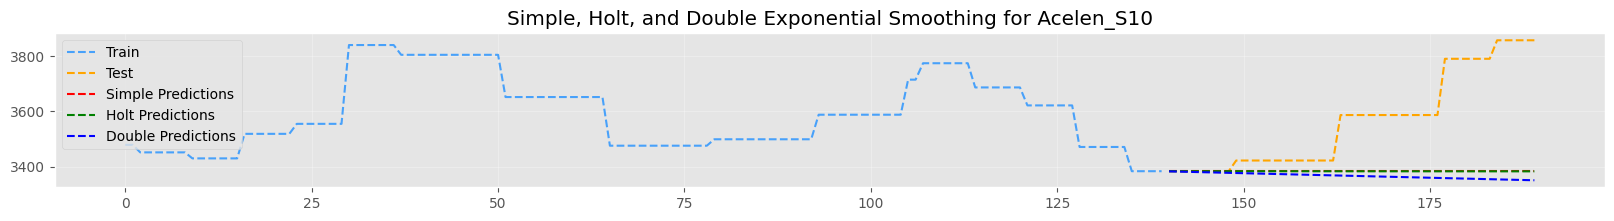

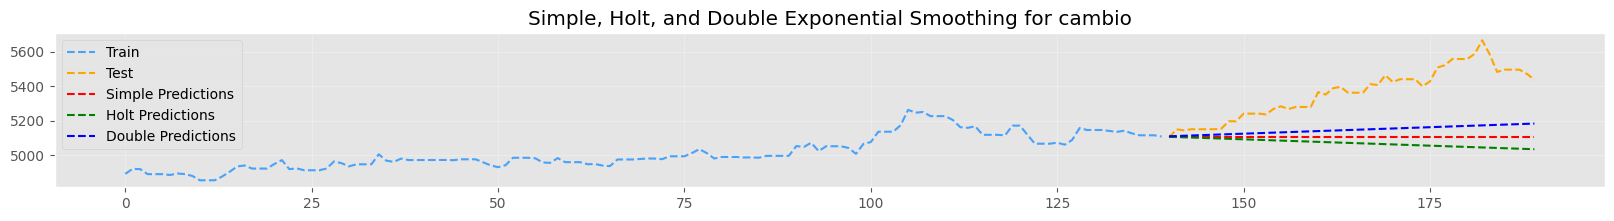

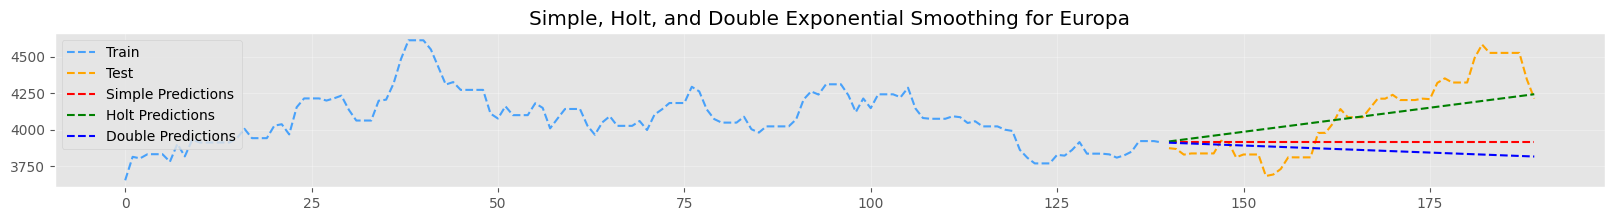

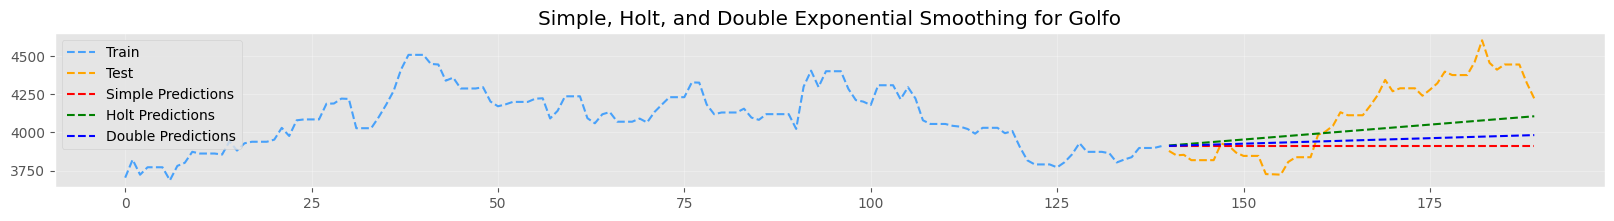

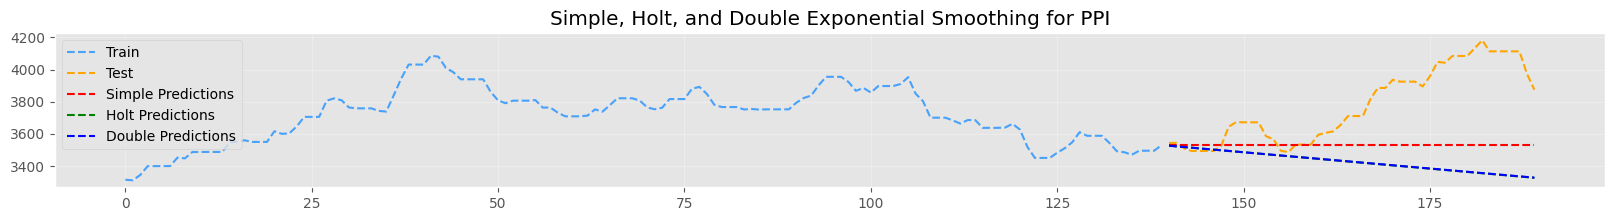

In [ ]:
# Função para calcular o erro quadrático médio (MSE)
def mse(observations, estimates):
    observations = np.array(observations)
    estimates = np.array(estimates)
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    difference = observations - estimates
    sq_diff = difference ** 2
    return np.mean(sq_diff)

# Iteração sobre as colunas de interesse
for column in columns_of_interest:
    col_prices = data[column].dropna()  # Remove valores NaN se houver
    category_name = column

    train = col_prices[:-50]
    test = col_prices[-50:]

    # Ajuste dos modelos de suavização
    simple = SimpleExpSmoothing(train).fit(optimized=True)
    single = Holt(train).fit(optimized=True)
    double = ExponentialSmoothing(train, trend='add', seasonal=None, seasonal_periods=12).fit(optimized=True)

    # Previsões
    simple_preds = simple.forecast(len(test))
    single_preds = single.forecast(len(test))
    double_preds = double.forecast(len(test))

    # Cálculo do MSE
    simple_mse = mse(test, simple_preds)
    single_mse = mse(test, single_preds)
    double_mse = mse(test, double_preds)

    # Exibição dos resultados do MSE
    data_dict = {'MSE': [simple_mse, single_mse, double_mse]}
    df = pd.DataFrame(data_dict, index=['simple', 'single', 'double'])
    # display(df)

    # Plotagem dos resultados
    fig, ax = plt.subplots(figsize=(20, 2))
    plt.plot(train.index, train.values, '#48A1FA', linestyle="--", label="Train")
    plt.plot(test.index, test.values, color='orange', linestyle="--", label="Test")
    plt.plot(test.index, simple_preds, 'r--', label="Simple Predictions")
    plt.plot(test.index, single_preds, 'g--', label="Holt Predictions")
    plt.plot(test.index, double_preds, 'b--', label="Double Predictions")
    plt.legend(loc='upper left')
    plt.title(f"Simple, Holt, and Double Exponential Smoothing for {category_name}")
    plt.grid(alpha=0.3)
    plt.show()


##### `F. Avaliação de Diferentes Modelos de Regressão Usando Combinações de Preditores`

In [ ]:
# Colunas que serão usadas como preditores
predictors = interference_col
# Coluna alvo
target = 'Acelen_S10'
# Combinações de preditores
predictor_combinations = []
for r in range(1, len(predictors) + 1):
    predictor_combinations.extend(combinations(predictors, r))

def evaluate_models(data, predictor_sets):
    results = []
    for predictors in predictor_sets:
        # Preparar os dados
        X = data[list(predictors)]
        y = data[target]
        # Divisão em conjuntos de treino e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Dicionário com os modelos a serem avaliados
        models = {
                'Regressão Linear': LinearRegression(),
                'Árvore de Decisão': DecisionTreeRegressor(random_state=42),
                'Floresta Aleatória': RandomForestRegressor(random_state=42),
                'Rede Neural': MLPRegressor(random_state=42),
                'Lasso': Lasso(random_state=42),
                'Regressão Log-Linear': make_pipeline(FunctionTransformer(np.log1p, validate=True), LinearRegression()),
                'KNN Regressor': KNeighborsRegressor(),
                'SVR': SVR(),
                'Gradient Boosting': GradientBoostingRegressor(random_state=42),
                'XGBoost': XGBRegressor(random_state=42),
                'LightGBM': LGBMRegressor(random_state=42),
                'ElasticNet': ElasticNet(random_state=42)
              }
        # Avaliar cada modelo
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            forecast = model.predict(X.tail(1))[0]  # Previsão do último valor
            key = '+'.join(predictors)
            results.append({'Predictores': key, 'Modelo': model_name, 'R^2': r2, 'Previsão': forecast})

    return results

# Avaliação dos modelos
model_results = evaluate_models(data, predictor_combinations)

# Criação do DataFrame de resultados e ordenação pelo R^2
results_df = pd.DataFrame(model_results)
results_df.sort_values(by=['R^2'], ascending=False, inplace=True)
results_df


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 1
[LightGBM] [Info] Start training from score 3585.427590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Predictores              Modelo       R^2     Previsão
158         Golfo+PPI+cambio  Floresta Aleatória  0.626280  3744.470000
109               PPI+cambio   Árvore de Decisão  0.625530  3856.700000
157         Golfo+PPI+cambio   Árvore de Decisão  0.616162  3856.700000
110               PPI+cambio  Floresta Aleatória  0.612623  3740.684000
134      Europa+Golfo+cambio  Floresta Aleatória  0.601882  3740.638000
..                       ...                 ...       ...          ...
171  Europa+Golfo+PPI+cambio         Rede Neural -2.948954  3932.036041
123         Europa+Golfo+PPI         Rede Neural -4.752383  3971.221896
147        Europa+PPI+cambio         Rede Neural -6.251420  4074.464275
159         Golfo+PPI+cambio         Rede Neural -6.505195  4073.491638
135      Europa+Golfo+cambio         Rede Neural -6.772764  4086.323988

[180 rows x 4 columns]

#### `6.4 - Forecasting by SARIMA model`

##### `6.4.1 - ACF & PACF`

#### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

In [ ]:
stepwise_model = pm.auto_arima(data['Acelen_S10'], start_p=1, start_q=1,
                               max_p=3, max_q=3, m=12,
                               start_P=0, seasonal=True,
                               d=0, D=1, trace=True,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=True)

# Imprimindo o AIC (Critério de Informação de Akaike) do modelo ajustado
print("AIC:", stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2284.216, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1904.009, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2104.417, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2287.372, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1947.397, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1882.938, Time=1.76 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.55 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2250.294, Time=1.83 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1881.996, Time=2.61 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1905.609, Time=0.87 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.11 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.31 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1

In [ ]:
# Extraindo os parâmetros para uso em SARIMAX
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order

# Configurando e ajustando o modelo SARIMAX com os parâmetros obtidos
sarimax_model = sm.tsa.statespace.SARIMAX(data['Acelen_S10'],
                                          order=order,
                                          seasonal_order=seasonal_order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False).fit()

# Exibindo o resumo do modelo
print(sarimax_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          Acelen_S10   No. Observations:                  190
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -787.727
Date:                             Wed, 10 Jul 2024   AIC                           1585.455
Time:                                     15:49:55   BIC                           1600.607
Sample:                                          0   HQIC                          1591.610
                                             - 190                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9650      0.030     32.393      0.000       0.907       1.023
ma.L1          0.1842      

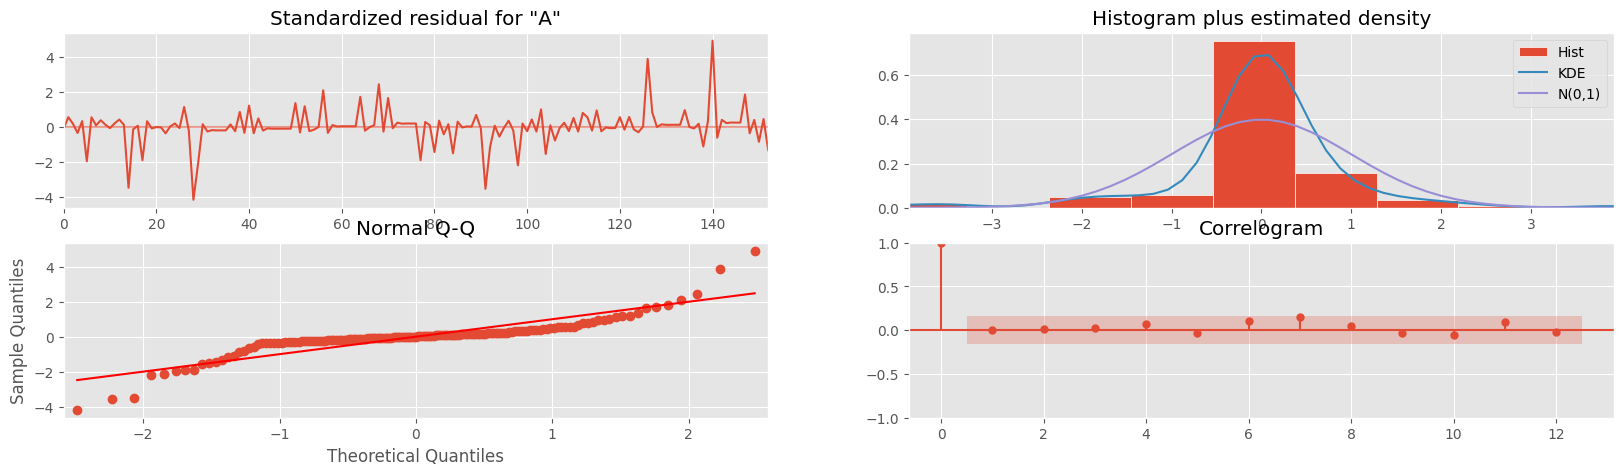

In [ ]:
# plot residual diagnostics
sarimax_model.plot_diagnostics(lags=12,figsize = (20,5),);

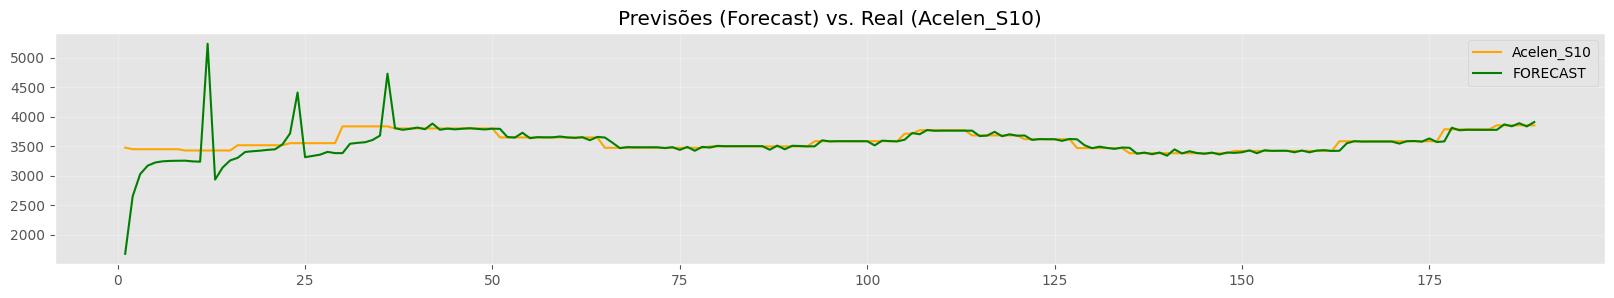

In [ ]:
pd.plotting.register_matplotlib_converters()
data['FORECAST'] = sarimax_model.predict(start=1, end=len(data))

# Criando figura e eixos explicitamente
fig, ax = plt.subplots(figsize=(20, 3))

# Usando o objeto de eixos para plotar
data[1:][['Acelen_S10', 'FORECAST']].plot(ax=ax, color=('orange', 'green'))
plt.title('Previsões (Forecast) vs. Real (Acelen_S10)')
plt.grid(alpha=0.3)
plt.show()

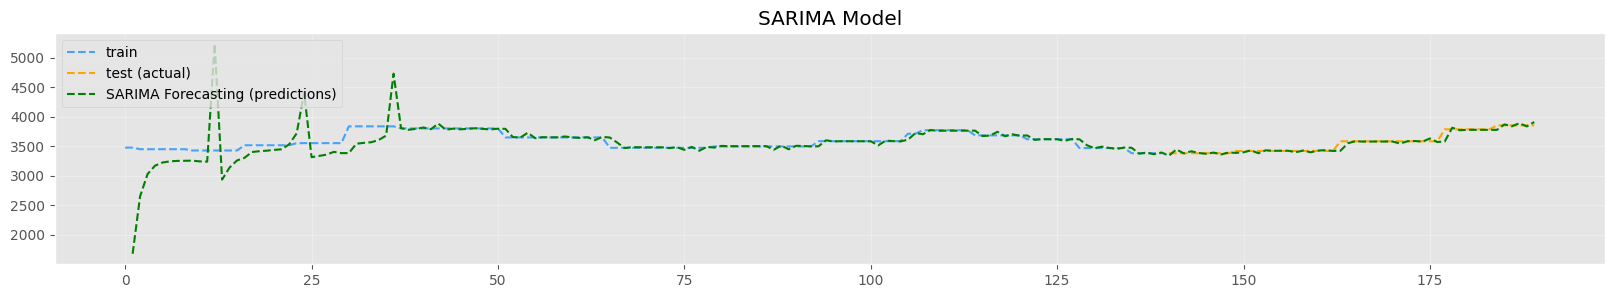

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
plt.plot(data['Acelen_S10'][:-50], '#48A1FA', linestyle="--", label="train")
plt.plot(data['Acelen_S10'][-50:], color='orange', linestyle="--", label="test (actual)")
plt.plot(data['FORECAST'], 'g--', label="SARIMA Forecasting (predictions)")
plt.legend(loc='upper left')
plt.title("SARIMA Model")
plt.grid(alpha=0.3);

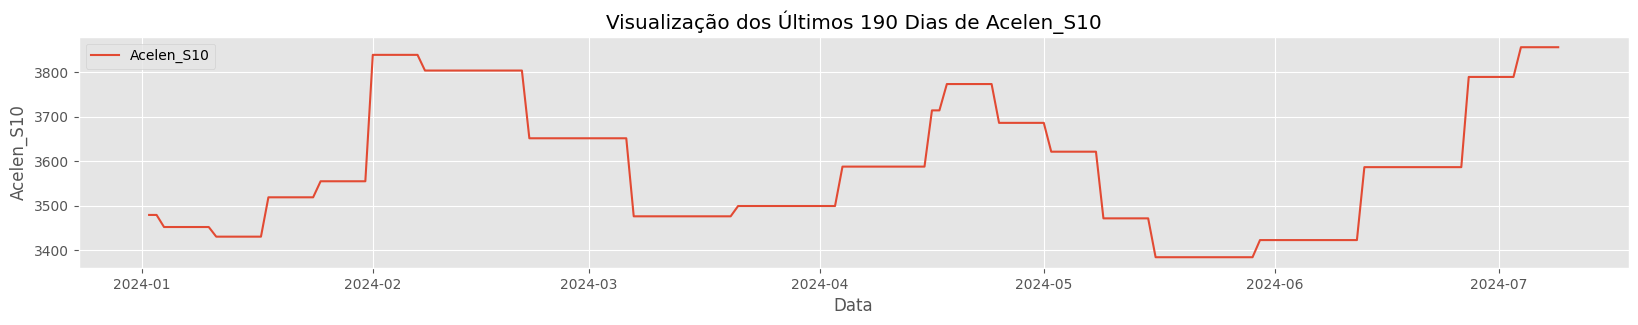

In [ ]:
# Determine dinamicamente o número de pontos de dados válidos
num_dados_desejados = data['Acelen_S10'].notna().sum()

# Certifique-se de que 'num_dados_desejados' está sendo usado corretamente
if num_dados_desejados > 0:
    actual = np.asarray(data['Acelen_S10'].dropna())

    # Visualização opcional com Matplotlib para verificar os dados
    plt.figure(figsize=(20, 3))
    plt.plot(data['Date'][-num_dados_desejados:], actual[-num_dados_desejados:], label='Acelen_S10')
    plt.title(f'Visualização dos Últimos {num_dados_desejados} Dias de Acelen_S10')
    plt.xlabel('Data')
    plt.ylabel('Acelen_S10')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Não há dados suficientes para análise após a limpeza.")

********
Modeling Acelen_S10 with predictors ['Europa', 'Golfo', 'PPI', 'cambio']
********

********
Modeling Acelen_S10 with predictors ['Europa', 'Golfo', 'PPI', 'cambio']
********


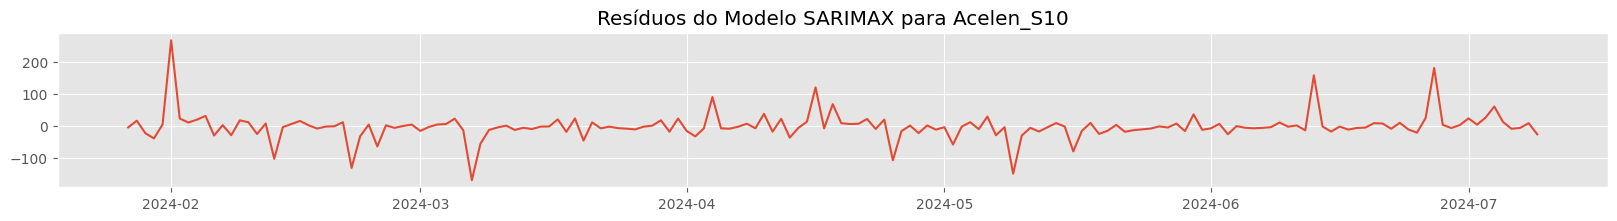

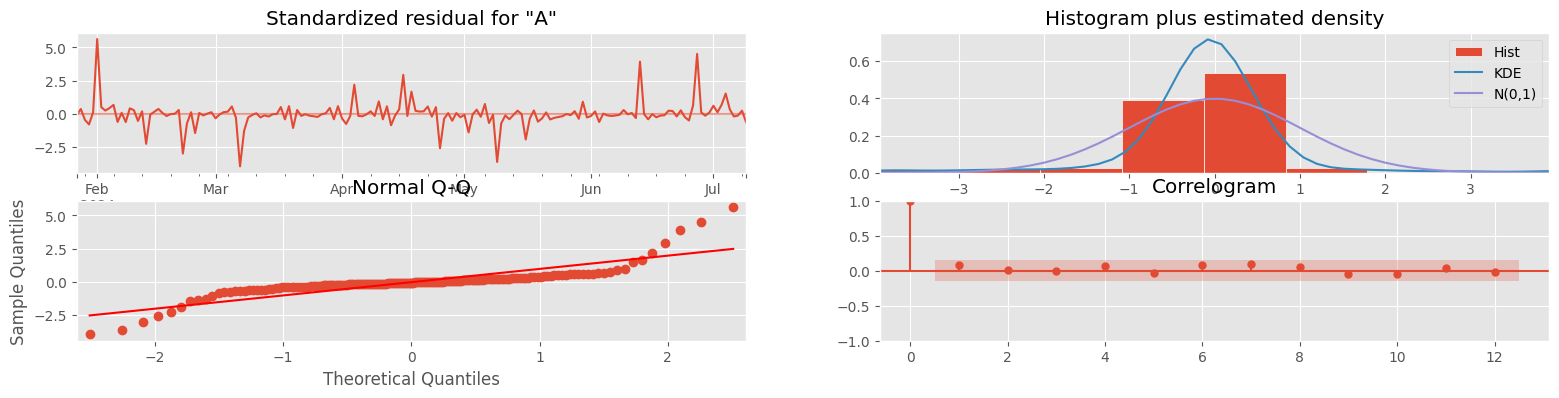

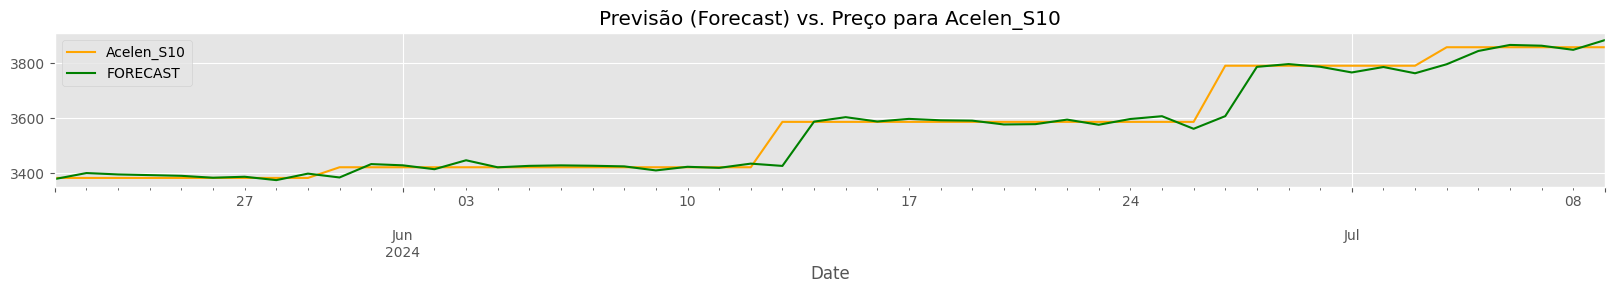

SARIMAX para Acelen_S10:
                                      SARIMAX Results                                       
Dep. Variable:                           Acelen_S10   No. Observations:                  190
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -851.267
Date:                              Wed, 10 Jul 2024   AIC                           1718.534
Time:                                      15:50:02   BIC                           1743.381
Sample:                                  01-02-2024   HQIC                          1728.620
                                       - 07-09-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3604      0.922      0.391      0.696      -1.446       

In [ ]:
# Função para ajustar e avaliar o modelo SARIMAX com preditores
def sarimax_with_predictors(data, target, predictors):
    df = data[['Date'] + predictors + [target]].dropna().reset_index(drop=True)
    df[target] = pd.to_numeric(df[target], errors='coerce')
    df.set_index('Date', inplace=True)

    print("********")
    print(f"Modeling {target} with predictors {predictors}")
    print("********")

    try:
        sar = sm.tsa.statespace.SARIMAX(
            df[target],
            exog=df[predictors],
            order=(1, 0, 0),
            seasonal_order=(0, 1, 1, 12),
            trend='c',
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
    except Exception as e:
        print(f"Erro ao ajustar o modelo SARIMAX para {target} com preditores {predictors}: {e}")
        return

    plt.figure(figsize=(20, 2))
    plt.plot(sar.resid[sar.loglikelihood_burn:])
    plt.title(f'Resíduos do Modelo SARIMAX para {target}')
    plt.show()

    sar.plot_diagnostics(lags=12, figsize=(19, 4))
    plt.show()

    df['FORECAST'] = sar.predict(start=len(df) - 50, end=len(df) - 1, exog=df[predictors])
    df[-50:][[target, 'FORECAST']].plot(color=('orange', 'g'), figsize=(20, 2))
    plt.title(f'Previsão (Forecast) vs. Preço para {target}')
    plt.show()

    print(f'SARIMAX para {target}:')
    print(sar.summary())

    actual = np.asarray(df[target][-50:])
    SARIMA_prediction = sar.predict(start=len(df) - 50, end=len(df) - 1, exog=df[predictors])

    SARIMA_mse = mean_squared_error(actual, SARIMA_prediction)
    print(f"MSE para {target}: {SARIMA_mse}")

    # Calcular o R^2 manualmente
    SARIMA_r2 = r2_score(actual, SARIMA_prediction)
    print(f"R^2 para {target}: {SARIMA_r2}")

    norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
    lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
    het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = sm.stats.stattools.durbin_watson(
        sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

    print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p))
    print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p))
    print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p))
    print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

    # Criar um dataframe com os resultados
    results_df = pd.DataFrame({
        'Predictors': [', '.join(predictors)],
        'Model': ['SARIMAX'],
        'R^2 Score': [SARIMA_r2],
        'Forecast': [SARIMA_prediction[-1]]
    })

    print(results_df.to_string(index=False))
    return results_df

# Aplicar o modelo
target_column = 'Acelen_S10'
predictor_columns = ['Europa', 'Golfo', 'PPI','cambio']

results= sarimax_with_predictors(data, target_column, predictor_columns)

##### `6.4.2 - Forecasting by Facebook Prophet model`

DEBUG:cmdstanpy:input tempfile: /tmp/tmpksb0gz6i/c29spnjn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpksb0gz6i/gm2v_uhy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93571', 'data', 'file=/tmp/tmpksb0gz6i/c29spnjn.json', 'init=/tmp/tmpksb0gz6i/gm2v_uhy.json', 'output', 'file=/tmp/tmpksb0gz6i/prophet_modelhi9wwj0m/prophet_model-20240710155002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:50:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:50:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


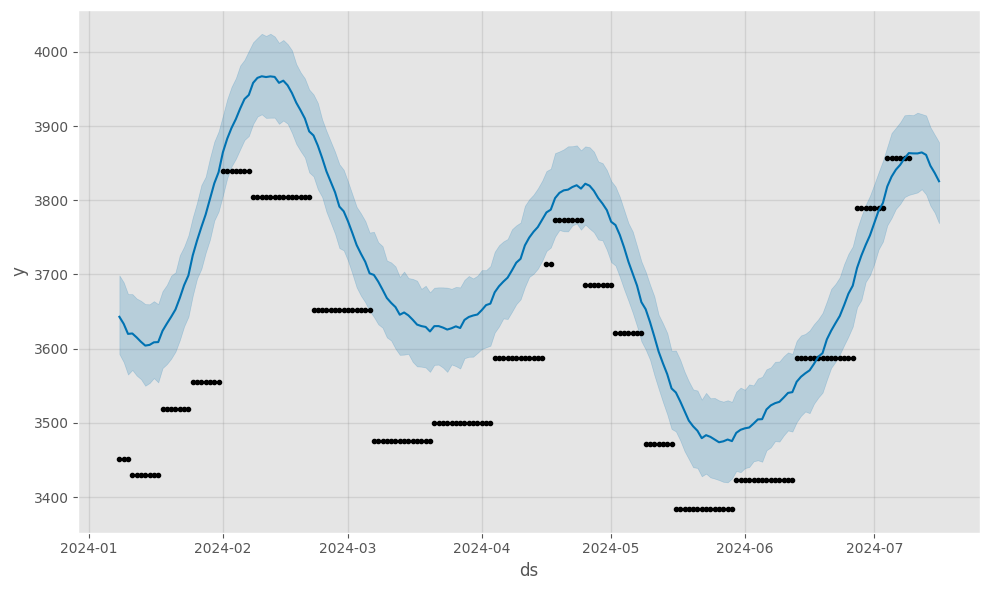

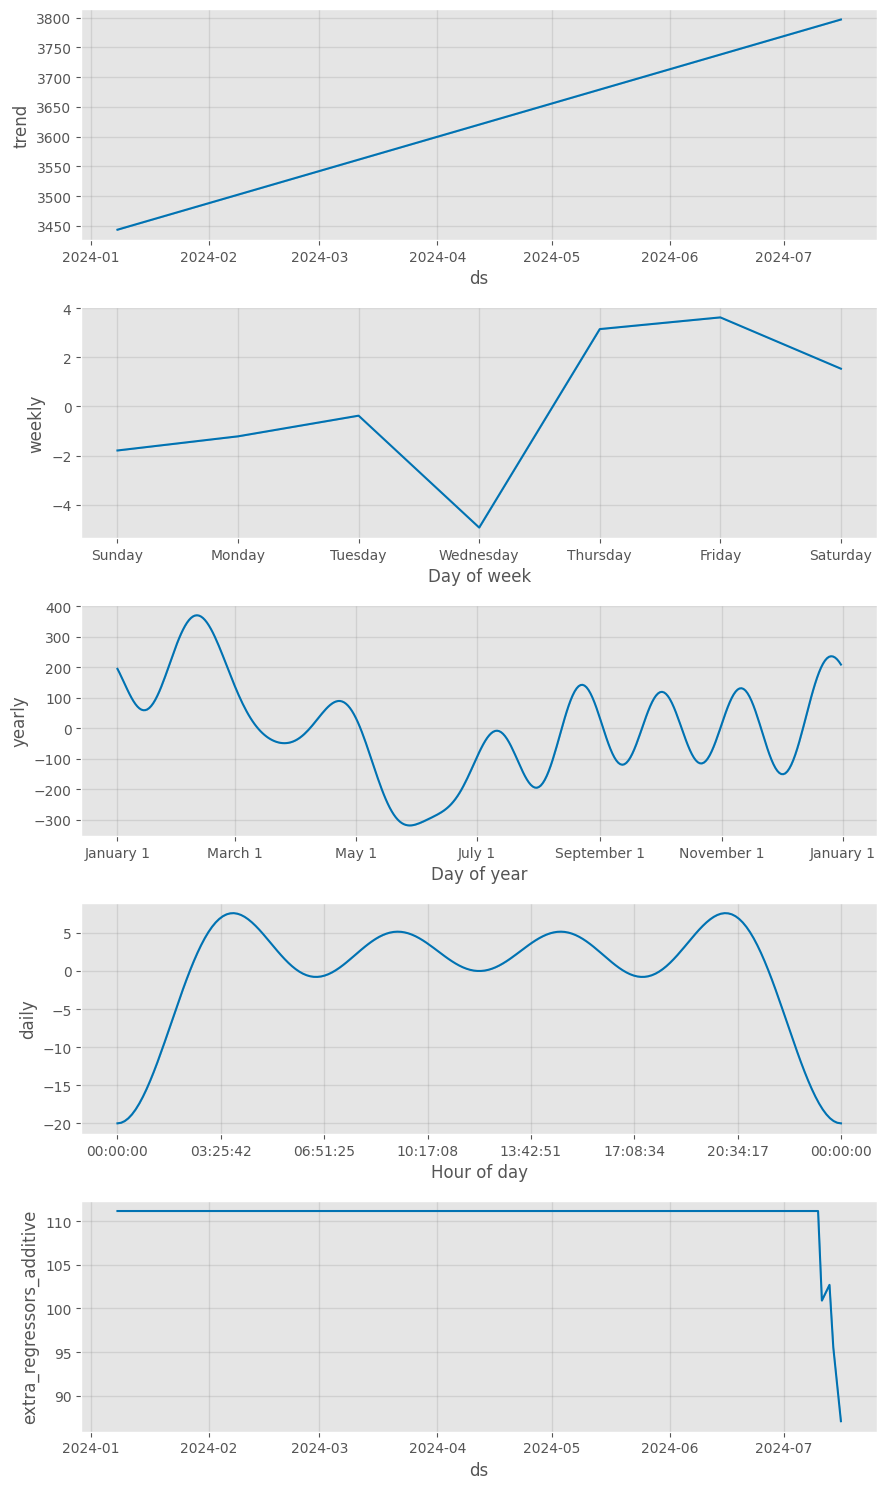

In [ ]:
# Converter strings numéricas formatadas para floats
def convert_to_float(value):
    if isinstance(value, str):
        return float(value.replace(',', '').replace('.', ''))
    return value

# Função para limpar e converter dados numéricos
def clean_numeric_data(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        df[column] = df[column].apply(lambda x: float(str(x).replace(' ', '').replace(',', '.')) if isinstance(x, str) else x)
    return df

# Colunas que precisam ser convertidas
columns_to_convert = ['Acelen_S10', 'cambio', 'Europa', 'Golfo', 'PPI']

for column in columns_to_convert:
    data[column] = data[column].apply(convert_to_float)

data = clean_numeric_data(data)
data['Acelen_S10'] = data['Acelen_S10']
data['Europa'] = data['Europa']
data['Golfo'] = data['Golfo']
data['PPI'] = data['PPI']
data['cambio'] = data['cambio']

# Configurar a data como coluna e reindexar para completar as datas faltantes
data.set_index('Date', inplace=True)
idx = pd.date_range(data.index.min(), data.index.max())
data = data.reindex(idx).rename_axis('Date').reset_index()

# Substituir zeros usando ffill para garantir que todos os valores sejam preenchidos
data.replace(0, np.nan, inplace=True)
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Criar colunas de lag
data['cambio_lag1'] = data['cambio'].shift(1)
data['Europa_lag6'] = data['Europa'].shift(6)
data['Golfo_lag6'] = data['Golfo'].shift(6)
data['PPI_lag6'] = data['PPI'].shift(6)
data.dropna(inplace=True)

# Renomear colunas para o formato do Prophet
data.rename(columns={'Date': 'ds', 'Acelen_S10': 'y'}, inplace=True)
data.tail()
# # Configuração do Modelo Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.add_regressor('cambio_lag1')
model.add_regressor('Europa_lag6')
model.add_regressor('Golfo_lag6')
model.add_regressor('PPI_lag6')
model.fit(data)

# Função para prever futuros valores de um regressor usando regressão linear
def predict_future_regressor(values, periods):
    model = LinearRegression()
    X = np.arange(len(values)).reshape(-1, 1)  # Dias como variável independente
    y = values
    model.fit(X, y)
    future_X = np.arange(len(values), len(values) + periods).reshape(-1, 1)
    return model.predict(future_X)

# Prever os regressores futuros para os próximos 7 dias
future_cambio = predict_future_regressor(data['cambio'], 7)
future_Europa = predict_future_regressor(data['Europa'], 7)
future_Golfo = predict_future_regressor(data['Golfo'], 7)
future_PPI = predict_future_regressor(data['PPI'], 7)

# Criar um DataFrame com datas futuras para previsão
future_dates = model.make_future_dataframe(periods=7)

# O índice inicial onde os valores futuros começam
start_index = len(data)

# Atribuir os valores previstos corretamente
future_dates.loc[start_index:, 'cambio_lag1'] = np.concatenate(([data['cambio'].iloc[-1]], future_cambio[:-1]))
future_dates.loc[start_index:, 'Europa_lag6'] = np.concatenate((data['Europa'].iloc[-6:], future_Europa[:-6]))
future_dates.loc[start_index:, 'Golfo_lag6'] = np.concatenate((data['Golfo'].iloc[-6:], future_Golfo[:-6]))
future_dates.loc[start_index:, 'PPI_lag6'] = np.concatenate((data['PPI'].iloc[-6:], future_PPI[:-6]))

# Preencher quaisquer NaNs resultantes com o valor imediatamente anterior
future_dates.fillna(method='bfill', inplace=True)
future_dates.fillna(method='ffill', inplace=True)

# # Fazer as previsões
forecast = model.predict(future_dates)

# # Visualizar as previsões
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

            ds         yhat   yhat_lower   yhat_upper
184 2024-07-10  3863.134110  3808.790721  3914.601776
185 2024-07-11  3863.069396  3810.478253  3917.960573
186 2024-07-12  3864.441429  3814.877027  3916.207334
187 2024-07-13  3861.149980  3807.793588  3914.230895
188 2024-07-14  3846.501548  3792.740980  3898.431508
189 2024-07-15  3836.769370  3783.225994  3888.310065
190 2024-07-16  3825.591660  3769.002295  3878.260755


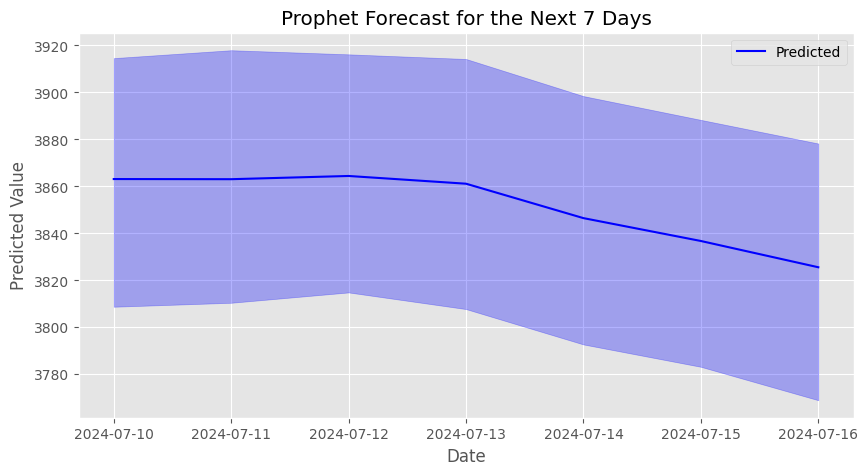

In [ ]:
# Extraindo as previsões para os próximos 7 dias
predicted_dates = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

# Exibindo os resultados
print(predicted_dates)

# Configuração da plotagem
plt.figure(figsize=(10, 5))
plt.plot(predicted_dates['ds'], predicted_dates['yhat'], label='Predicted', color='blue')
plt.fill_between(predicted_dates['ds'], predicted_dates['yhat_lower'], predicted_dates['yhat_upper'], color='blue', alpha=0.3)
plt.title('Prophet Forecast for the Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.grid(True)
plt.legend()
plt.show()


##### `6.4.3 - Neural Networking - Multilayer Perceptron model`

In [ ]:
file_path = '/content/Comparativo_Acelen_20240708.csv'
data = pd.read_csv(file_path,sep=";")

In [ ]:
# Converter a coluna 'Date' para datetime
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data[data['Date'].dt.year == 2024]
data = data[['Date','Acelen_S10','cambio','Europa', 'Golfo', 'PPI']].dropna().copy(deep='True')
data['cambio'] = data['cambio'] * 1_000

# Função para limpar e converter dados numéricos
def clean_numeric_data(value):
    if isinstance(value, str):
        return float(value.replace(' ', '').replace('.', '').replace(',', '.'))
    return value

# Aplicar a função de limpeza
for column in data.columns[1:]:
    data[column] = data[column].apply(clean_numeric_data)

# Configurar a data como coluna e reindexar para completar as datas faltantes
data.set_index('Date', inplace=True)
idx = pd.date_range(data.index.min(), data.index.max())
data = data.reindex(idx).rename_axis('Date').reset_index()

# Substituir zeros usando ffill para garantir que todos os valores sejam preenchidos
for column in data.columns[1:]:  # Ignorar a coluna 'Date'
    # Primeiro, substituir zeros com NaN para permitir o uso de ffill
    data[column].replace(0, np.nan, inplace=True)
    # Aplicar ffill
    data[column].ffill(inplace=True)
    # Se ainda houver NaNs (caso a série começasse com zero), aplicar bfill
    data[column].bfill(inplace=True)

# Checar se há algum NaN ou zero restante
assert (data.set_index('Date') == 0).any().any() == False, "Ainda há zeros no DataFrame."
assert data.set_index('Date').isnull().any().any() == False, "Ainda há NaNs no DataFrame."

# Mostrar os dados preparados
print(data.tail(10))

          Date  Acelen_S10  cambio   Europa    Golfo      PPI
180 2024-06-30      3789.8  5558.9  4322.88  4377.63  4084.03
181 2024-07-01      3789.8  5589.3  4490.63  4463.06  4132.14
182 2024-07-02      3789.8  5667.7  4581.99  4606.42  4181.63
183 2024-07-03      3789.8  5586.3  4525.10  4457.87  4112.91
184 2024-07-04      3856.7  5483.9  4525.10  4413.17  4112.91
185 2024-07-05      3856.7  5497.0  4525.10  4447.07  4112.91
186 2024-07-06      3856.7  5497.0  4525.10  4447.07  4112.91
187 2024-07-07      3856.7  5497.0  4525.10  4447.07  4112.91
188 2024-07-08      3856.7  5472.0  4344.85  4325.62  3972.80
189 2024-07-09      3856.7  5438.7  4213.75  4223.15  3874.47


In [ ]:
# Converter strings numéricas formatadas para floats
def convert_to_float(value):
    if isinstance(value, str):
        return float(value.replace(',', '').replace('.', ''))
    return value

# Função para limpar e converter dados numéricos
def clean_numeric_data(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        df[column] = df[column].apply(lambda x: float(str(x).replace(' ', '').replace(',', '.')) if isinstance(x, str) else x)
    return df

# Colunas que precisam ser convertidas
columns_to_convert = ['Acelen_S10', 'cambio', 'Europa', 'Golfo', 'PPI']

for column in columns_to_convert:
    data[column] = data[column].apply(convert_to_float)

data = clean_numeric_data(data)
data['Acelen_S10'] = data['Acelen_S10']
data['Europa'] = data['Europa']
data['Golfo'] = data['Golfo']
data['PPI'] = data['PPI']
data['cambio'] = data['cambio'] * 1_000

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout

In [ ]:
df_diesel_sales = data[['Date', 'Acelen_S10']]
df_diesel_sales = df_diesel_sales.groupby(['Date']).sum()
# df_diesel_sales.index = pd.to_datetime(df_diesel_sales.index)
print(df_diesel_sales)

# split into train and test sets
train_size = int(len(df_diesel_sales) * 0.70)
test_size = len(df_diesel_sales) - train_size
train, test = df_diesel_sales[0:train_size][:].values, df_diesel_sales[train_size:len(df_diesel_sales)][:].values
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

 # reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

            Acelen_S10
Date                  
2024-01-02      3479.1
2024-01-03      3479.1
2024-01-04      3451.9
2024-01-05      3451.9
2024-01-06      3451.9
...                ...
2024-07-05      3856.7
2024-07-06      3856.7
2024-07-07      3856.7
2024-07-08      3856.7
2024-07-09      3856.7

[190 rows x 1 columns]
133 57
Epoch 1/200
66/66 - 1s - loss: 1180823.3750 - 705ms/epoch - 11ms/step
Epoch 2/200
66/66 - 0s - loss: 64868.2500 - 89ms/epoch - 1ms/step
Epoch 3/200
66/66 - 0s - loss: 1776.4259 - 107ms/epoch - 2ms/step
Epoch 4/200
66/66 - 0s - loss: 1611.3231 - 89ms/epoch - 1ms/step
Epoch 5/200
66/66 - 0s - loss: 1637.9309 - 122ms/epoch - 2ms/step
Epoch 6/200
66/66 - 0s - loss: 1618.3505 - 89ms/epoch - 1ms/step
Epoch 7/200
66/66 - 0s - loss: 1621.5590 - 84ms/epoch - 1ms/step
Epoch 8/200
66/66 - 0s - loss: 1613.2311 - 89ms/epoch - 1ms/step
Epoch 9/200
66/66 - 0s - loss: 1640.2675 - 104ms/epoch - 2ms/step
Epoch 10/200
66/66 - 0s - loss: 1650.4650 - 89ms/epoch - 1ms/step
Epoch 11/2

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictPlot = np.empty_like(df_diesel_sales)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(df_diesel_sales)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_diesel_sales)-1, :] = testPredict

2/2 [==============================] - 0s 5ms/step


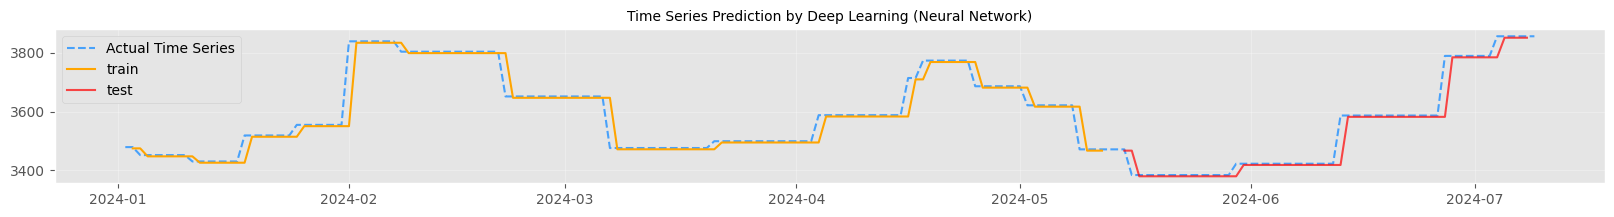

In [ ]:
trainPredictPlot_col = trainPredictPlot[:, 0]
testPredictPlot_col = testPredictPlot[:, 0]

diesel_sales_series = df_diesel_sales['Acelen_S10']

trainPredictPlot_series = pd.Series(trainPredictPlot_col, index=diesel_sales_series.index[:len(trainPredictPlot_col)])
testPredictPlot_series = pd.Series(testPredictPlot_col, index=diesel_sales_series.index[-len(testPredictPlot_col):])

fig, ax = plt.subplots(figsize=(20,2))
plt.plot(diesel_sales_series, '#48A1FA', linestyle="--", label="Actual Time Series")
plt.plot(trainPredictPlot_series, 'orange', linestyle="-", label="train")
plt.plot(testPredictPlot_series, color='red', linestyle="-", label="test", alpha=0.7)
plt.legend(loc='upper left')
plt.title("Time Series Prediction by Deep Learning (Neural Network)", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

##### `6.4.3.2 - Prever os próximos 7 dias`

In [ ]:
# Define a função para fazer previsões recorrentes
def predict_next_days(model, input_array, n_days):
    # Inicializa a lista de previsões futuras
    future_predictions = []
    # Usa a última janela de entrada para começar a fazer previsões futuras
    current_input = input_array[-look_back:]

    # Itera para fazer previsões por n dias
    for _ in range(n_days):
        # Faz uma previsão utilizando a janela de entrada atual
        next_prediction = model.predict(current_input.reshape((1, look_back)))
        # Adiciona a previsão na lista de previsões futuras
        future_predictions.append(next_prediction[0, 0])
        # Atualiza a janela de entrada para incluir a nova previsão
        current_input = np.roll(current_input, -1)
        current_input[-1] = next_prediction

    return future_predictions

# Prever os próximos 7 dias
future_days = 7
future_predictions = predict_next_days(model, testX, future_days)

# Mostra as previsões
print("Previsões para os próximos 7 dias:")
for i, prediction in enumerate(future_predictions, 1):
    print(f"Dia {i}: {prediction:.2f}")

1/1 [==============================] - 0s 22ms/step
Previsões para os próximos 7 dias:
Dia 1: 3851.77
Dia 2: 3846.85
Dia 3: 3841.94
Dia 4: 3837.03
Dia 5: 3832.13
Dia 6: 3827.24
Dia 7: 3822.36


##### `6.4.2 Time Series Prediction by RNN`

2/2 [==============================] - 0s 4ms/step
Test Score: 1570.19 MSE


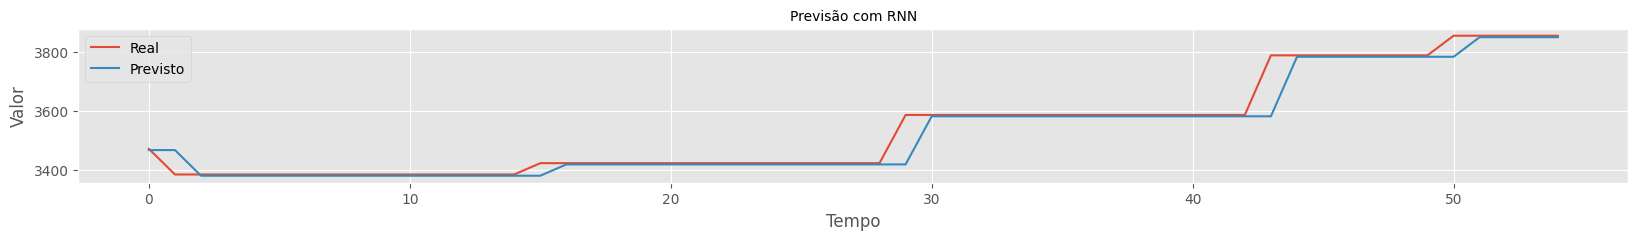

In [ ]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs, input_shape):
    """
    Fit a Simple RNN to training data.

    Arguments:
    - train_X (array): Input sequence samples for training, expected shape (samples, time_steps, features).
    - train_y (array): Target values for each sample in train_X.
    - cell_units (int): Number of hidden units in RNN cells.
    - epochs (int): Number of training epochs.
    - input_shape (tuple): Shape of the input data, excluding the batch size.

    Returns:
    - Trained Keras model object.
    """

    model = Sequential()
    model.add(SimpleRNN(cell_units, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

testPredict = model.predict(testX)
testScore = mean_squared_error(testY, testPredict)
print(f'Test Score: {testScore:.2f} MSE')

plt.figure(figsize=(20,2))
plt.plot(testY, label='Real')
plt.plot(testPredict, label='Previsto')
plt.title('Previsão com RNN', fontsize=10)
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

##### `6.4.3 Time Series Prediction by LSTM`

In [ ]:
# Ler e processar os dados
file_path = '/content/Comparativo_Acelen_20240708.csv'
data = pd.read_csv(file_path,sep=";")

# Converter a coluna 'Date' para datetime
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data[data['Date'].dt.year == 2024]
data = data[['Date','Acelen_S10','cambio','Europa', 'Golfo', 'PPI']].dropna().copy(deep='True')
data['cambio'] = data['cambio'] * 1_000

# Função para limpar e converter dados numéricos
def clean_numeric_data(value):
    if isinstance(value, str):
        return float(value.replace(' ', '').replace('.', '').replace(',', '.'))
    return value

# Aplicar a função de limpeza
for column in data.columns[1:]:
    data[column] = data[column].apply(clean_numeric_data)

# Configurar a data como coluna e reindexar para completar as datas faltantes
data.set_index('Date', inplace=True)
idx = pd.date_range(data.index.min(), data.index.max())
data = data.reindex(idx).rename_axis('Date').reset_index()

# Substituir zeros usando ffill para garantir que todos os valores sejam preenchidos
for column in data.columns[1:]:  # Ignorar a coluna 'Date'
    # Primeiro, substituir zeros com NaN para permitir o uso de ffill
    data[column].replace(0, np.nan, inplace=True)
    # Aplicar ffill
    data[column].ffill(inplace=True)
    # Se ainda houver NaNs (caso a série começasse com zero), aplicar bfill
    data[column].bfill(inplace=True)

# Checar se há algum NaN ou zero restante
assert (data.set_index('Date') == 0).any().any() == False, "Ainda há zeros no DataFrame."
assert data.set_index('Date').isnull().any().any() == False, "Ainda há NaNs no DataFrame."

# Mostrar os dados preparados
print(data.tail(10))

          Date  Acelen_S10  cambio   Europa    Golfo      PPI
180 2024-06-30      3789.8  5558.9  4322.88  4377.63  4084.03
181 2024-07-01      3789.8  5589.3  4490.63  4463.06  4132.14
182 2024-07-02      3789.8  5667.7  4581.99  4606.42  4181.63
183 2024-07-03      3789.8  5586.3  4525.10  4457.87  4112.91
184 2024-07-04      3856.7  5483.9  4525.10  4413.17  4112.91
185 2024-07-05      3856.7  5497.0  4525.10  4447.07  4112.91
186 2024-07-06      3856.7  5497.0  4525.10  4447.07  4112.91
187 2024-07-07      3856.7  5497.0  4525.10  4447.07  4112.91
188 2024-07-08      3856.7  5472.0  4344.85  4325.62  3972.80
189 2024-07-09      3856.7  5438.7  4213.75  4223.15  3874.47


*****
### LSTM1
*****

100%|██████████| 50/50 [12:19<00:00, 14.78s/trial, best loss: 0.05177681026647046]
Melhores parâmetros: {'hidden_size': 100, 'num_layers': 3, 'learning_rate': 0.010081232500781722, 'num_epochs': 500}
Previsão do preço do diesel para Acelen_S10: 3893.0096385431293
RMSE: 26.553076725805
MAE: 21.858809805964807
          Real     Previsão
0  3819.350371  3784.688721
1  3600.812646  3629.865234
2  3549.386250  3510.895264
3  3513.433428  3520.619873
4  3653.070604  3609.577637


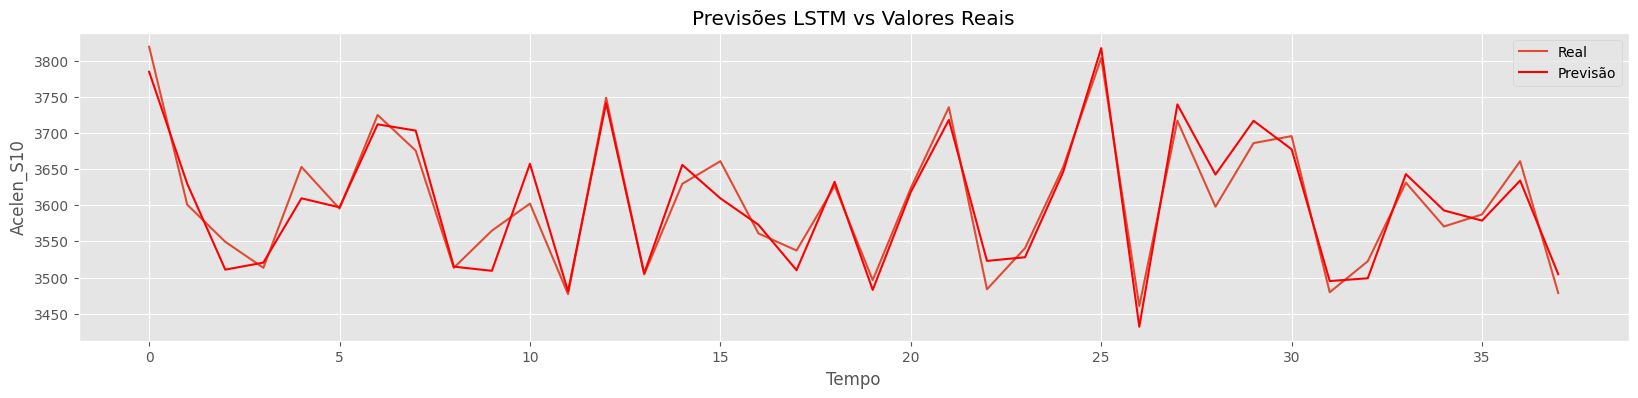

In [ ]:
# Selecionar as colunas de interesse
columns_of_interest = ['Acelen_S10', 'cambio', 'Europa', 'Golfo', 'PPI']
data = data[['Date'] + columns_of_interest]

# Função para preparar os dados para LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Definir o modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Normalizar os dados
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data[columns_of_interest])

# Preparar os dados para LSTM
n_steps = best_lag
X, y = prepare_data(data_normalized, n_steps)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter os dados para tensores do PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir o espaço de busca dos hiperparâmetros
space = {
    'hidden_size': hp.choice('hidden_size', [50, 75, 100]),
    'num_layers': hp.choice('num_layers', [1, 2, 3]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'num_epochs': hp.choice('num_epochs', [500, 1000, 1500, 2000])
}

# Função para treinar e avaliar o modelo
def objective(params):
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']

    model = LSTMModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        outputs = model(torch.tensor(X_train, dtype=torch.float32).to(device))
        optimizer.zero_grad()
        loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device))
        y_pred = y_pred.cpu().numpy()
        y_test_np = y_test

        rmse = mean_squared_error(y_test_np, y_pred, squared=False)

    return {'loss': rmse, 'status': STATUS_OK}

# Otimização Bayesiana usando Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Obter os melhores hiperparâmetros
best_params = {
    'hidden_size': [50, 75, 100][best['hidden_size']],
    'num_layers': [1, 2, 3][best['num_layers']],
    'learning_rate': best['learning_rate'],
    'num_epochs': [500, 1000, 1500, 2000][best['num_epochs']]
}
print(f'Melhores parâmetros: {best_params}')

# Treinar o modelo com os melhores hiperparâmetros
best_model = LSTMModel(input_size=X_train.shape[2], hidden_size=best_params['hidden_size'], num_layers=best_params['num_layers']).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()

num_epochs = best_params['num_epochs']
for epoch in range(num_epochs):
    best_model.train()
    outputs = best_model(torch.tensor(X_train, dtype=torch.float32).to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device))
    loss.backward()
    optimizer.step()

# Prever o preço do diesel na semana seguinte usando o melhor modelo
with torch.no_grad():
    X_last = torch.tensor(data_normalized[-n_steps:, :-1].reshape(1, n_steps, -1), dtype=torch.float32).to(device)
    forecast = best_model(X_last).cpu().numpy()
    forecast_full = np.append(data_normalized[-1, :-1], forecast)
    forecast_full = forecast_full.reshape(1, -1)
    forecast = scaler.inverse_transform(forecast_full)[:, -1][-1]
    print(f'Previsão do preço do diesel para Acelen_S10: {forecast}')

# Inverter a normalização para a coluna alvo
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(data[['Acelen_S10']].dropna())

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calcular as previsões no conjunto de teste
best_model.eval()
with torch.no_grad():
    y_pred = best_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

y_pred_inv = scaler_y.inverse_transform(y_pred)

# Calcular métricas de erro
rmse_lstm = mean_squared_error(y_test_inv, y_pred_inv, squared=False)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)

# Exibir resultados
print(f'RMSE: {rmse_lstm}')
print(f'MAE: {mae_lstm}')

df_results = pd.DataFrame({'Real': y_test_inv.flatten(), 'Previsão': y_pred_inv.flatten()})
df_results.to_csv('previsoes_lstm.csv', index=False)
print(df_results.head())

# Plotar as previsões e os valores reais
plt.figure(figsize=(20, 4))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsão', color='red')
plt.title('Previsões LSTM vs Valores Reais')
plt.xlabel('Tempo')
plt.ylabel('Acelen_S10')
plt.legend()
plt.grid(True)
plt.show()


*****
### Adicionando explicação com LIME
*****

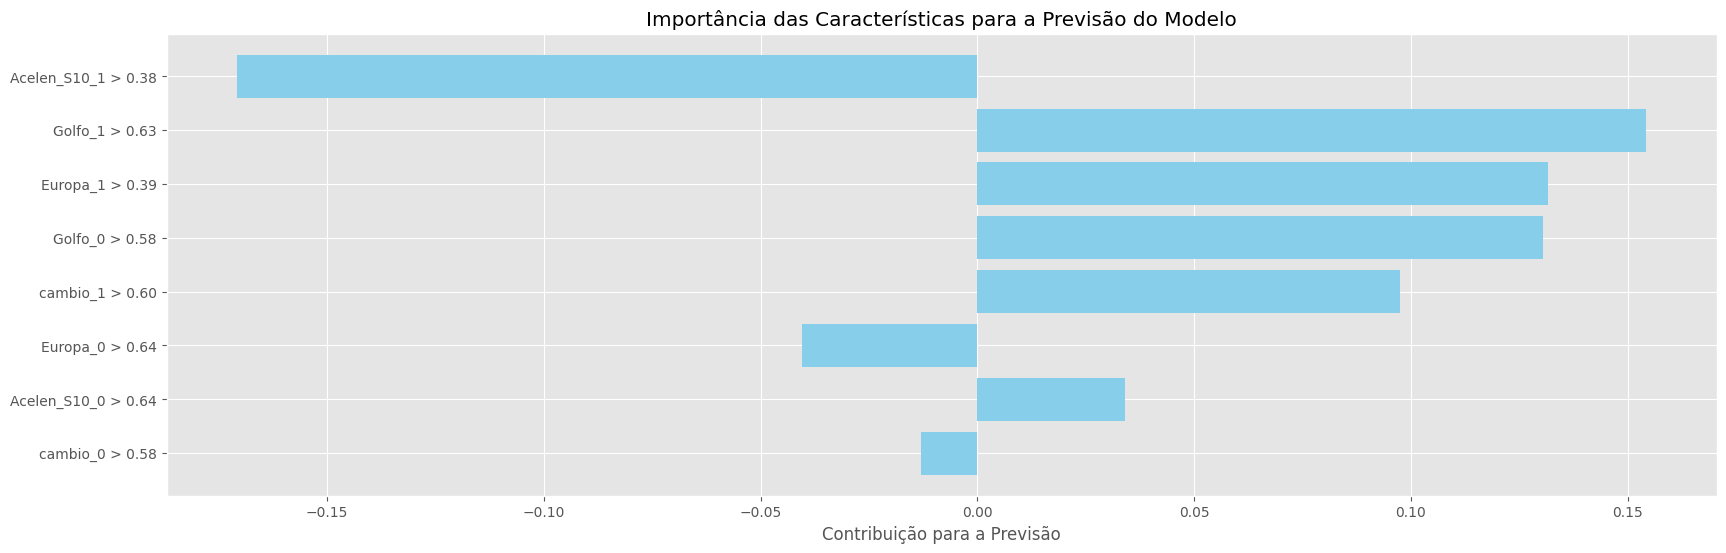

In [ ]:
# Função de previsão adaptada para LIME
def lime_predict(X):
    X_torch = torch.tensor(X.reshape(-1, n_steps, X_train.shape[2]), dtype=torch.float32).to(device)
    with torch.no_grad():
        return best_model(X_torch).cpu().numpy()

# Criar o explicador LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.reshape(X_train.shape[0], -1),
    feature_names=[f'{col}_{i}' for col in columns_of_interest for i in range(n_steps)],
    class_names=['price'],
    mode='regression'
)

# Explicar uma instância específica
i = 0  # Índice da instância a ser explicada
exp = explainer.explain_instance(
    data_row=X_test.reshape(X_test.shape[0], -1)[i],
    predict_fn=lime_predict
)

# Visualizar a explicação no notebook
exp.show_in_notebook(show_all=False)

# Para uma visualização gráfica
feature_importances = exp.as_list()
features = [x[0] for x in feature_importances]
importances = [x[1] for x in feature_importances]

plt.figure(figsize=(20, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Contribuição para a Previsão')
plt.title('Importância das Características para a Previsão do Modelo')
plt.gca().invert_yaxis()  # Inverter o eixo Y para que as características mais importantes estejam no topo
plt.show()


### `See you next time`